<a href="https://colab.research.google.com/github/Ciss48/Game_Analysis/blob/main/ds03_mock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
project_id = 'coffee-please-b767a'

In [3]:
from google.colab import auth
auth.authenticate_user()
# Construct a BigQuery client object.
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [4]:
# Xem các event_name (tiện truy vấn sau này)
query = """
SELECT DISTINCT event_name
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE NOT REGEXP_CONTAINS(event_name, r'_(\d+)$')
"""
event_name = client.query(query).to_dataframe()
event_name

,event_name
0,in_app_purchase
1,watch_rw60
2,purchased_coin2
3,ads_reward_click
4,purchase_kHint1
...,...
92,first_open
93,purchase_kCoin3
94,purchased_coin5
95,purchase_kRemoveAds


# EDA

In [ ]:
# Tìm min_ max date
query = """
select min(date_par) as min_date, max(date_par) as max_date from `royal-hexa-in-house.pixon_data_science.003_mock`
"""
min_max_date = client.query(query).to_dataframe()
min_max_date

,min_date,max_date
0,2025-02-01,2025-02-28


In [ ]:
# Có bao nhiêu platform trong dataset
query = """
select distinct platform from `royal-hexa-in-house.pixon_data_science.003_mock`
"""
platform = client.query(query).to_dataframe()
platform

,platform
0,IOS
1,ANDROID


In [ ]:
# Có bao nhiêu app_version đối với mỗi platform
query = """
select distinct platform, version from `royal-hexa-in-house.pixon_data_science.003_mock`
"""
appversion = client.query(query).to_dataframe()
appversion

,platform,version
0,ANDROID,0.2.1
1,ANDROID,0.7.26
2,ANDROID,0.1.6
3,IOS,0.7.7
4,IOS,0.4
5,ANDROID,0.7.23
6,ANDROID,0.6.5
7,IOS,0.3
8,ANDROID,0.4.2
9,IOS,0.6.7


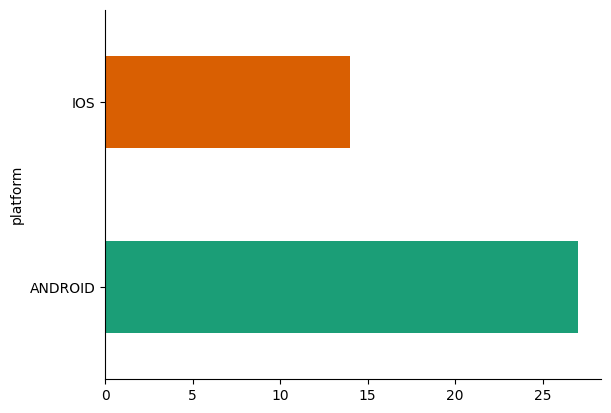

In [ ]:
# @title platform

from matplotlib import pyplot as plt
import seaborn as sns
appversion.groupby('platform').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## IOS

In [ ]:
# Đánh giá version còn hoạt động đối với mỗi platform
# IOS
query = """
select version, count(distinct user_pseudo_id) as num_user, min(date_par) as date_release
from `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE platform = 'IOS'
group by version order by num_user
"""
user_per_appversion_IOS = client.query(query).to_dataframe()
user_per_appversion_IOS

,version,num_user,date_release
0,0.1,1,2025-02-01
1,0.4,1,2025-02-09
2,0.1.1,11,2025-02-01
3,0.2.1,17,2025-02-02
4,0.5.1,19,2025-02-01
5,0.3,25,2025-02-01
6,0.6.4,471,2025-02-01
7,0.7.2,697,2025-02-01
8,0.6.7,1389,2025-02-01
9,0.7.4,3806,2025-02-01


Chỉ lấy 4 app là:
- 0.7.7: Đã được ra mắt từ trước
- 0.7.13: Được ra mắt từ ngày 20/2
- 0.7.12: Được ra mắt từ ngày 12/2
- 0.7.9: Được ra mắt từ trước

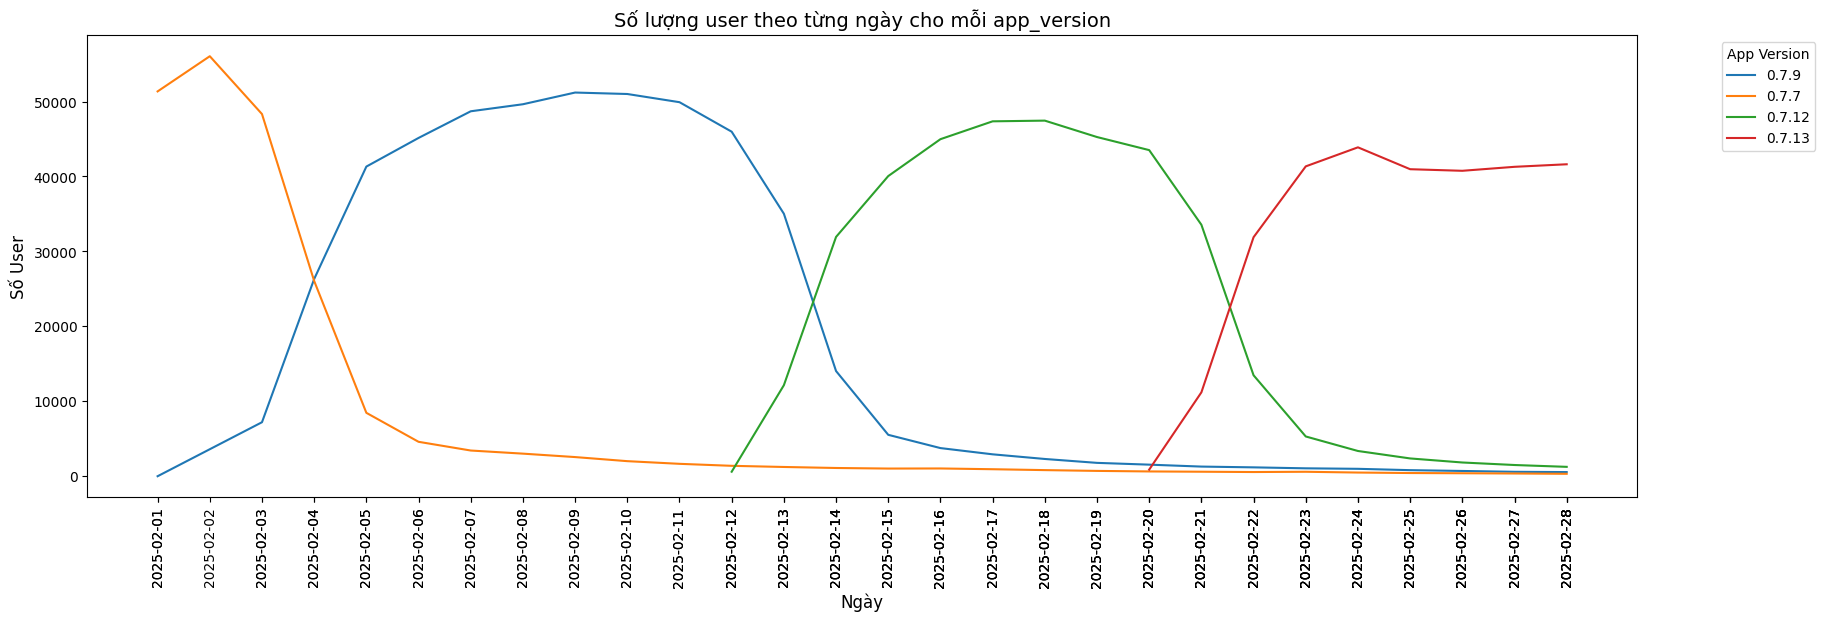

In [ ]:
#DAU đối với những app còn hoạt động của IOS
query = """
select version, date_par, count(distinct user_pseudo_id) as num_user_active
from `royal-hexa-in-house.pixon_data_science.003_mock`
where version in ('0.7.7', '0.7.13', '0.7.12', '0.7.9')
and event_name = 'user_engagement' and platform = 'IOS'
group by version, date_par order by date_par
"""
user_per_appversion_date_IOS = client.query(query).to_dataframe()
# Vẽ biểu đồ
plt.figure(figsize=(20, 6))
sns.lineplot(data=user_per_appversion_date_IOS, x="date_par", y="num_user_active", hue="version", palette="tab10")

# Tùy chỉnh biểu đồ
plt.xlabel("Ngày", fontsize=12)
plt.ylabel("Số User", fontsize=12)
plt.title("Số lượng user theo từng ngày cho mỗi app_version", fontsize=14)

# Xoay dọc các nhãn x để hiển thị hết giá trị
plt.xticks(rotation=90)
plt.gca().set_xticks(user_per_appversion_date_IOS["date_par"])
# Hiển thị legend ở vị trí bên phải
plt.legend(title="App Version", bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiển thị biểu đồ
plt.show()

- version 0.7.9 được ra mắt sau 0.7.7 vào ngày 1/2 nên user từ version 0.7.7 nhảy hết sang 0.7.9
- Sau đó từ ngày 12 version 0.7.12 được ra mắt nên user từ 0.7.9 sang hết 0.7.12
- Tương tự 0.7.13 ra mắt ngày 20, user từ 0.7.12 qua hết 0.7.13

**Như vậy đối với phiên bản IOS ta sẽ đánh giá 3 version là: 0.7.9; 0.7.12; 0.7.13**

## Android

In [ ]:
# Đánh giá version còn hoạt động đối với mỗi platform
# ANDROID
query = """
select version, count(distinct user_pseudo_id) as num_user, min(date_par) as date_release
from `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE platform = 'ANDROID'
group by version order by num_user
"""
user_per_appversion_android = client.query(query).to_dataframe()
user_per_appversion_android

,version,num_user,date_release
0,0.7.25,6,2025-02-10
1,0.7.26,6,2025-02-11
2,0.8.6,6,2025-02-26
3,0.8.1,6,2025-02-14
4,0.8.5,6,2025-02-25
5,0.8.4,6,2025-02-25
6,0.7.23,10,2025-02-06
7,0.7.22,11,2025-02-06
8,0.3.1,187,2025-02-01
9,0.1.6,192,2025-02-01


Lấy các version > 100k user để đánh giá tiếp: 0.8.8; 0.7.20; 0.7.24; 0.7.28, 0.8.3, 0.7.21

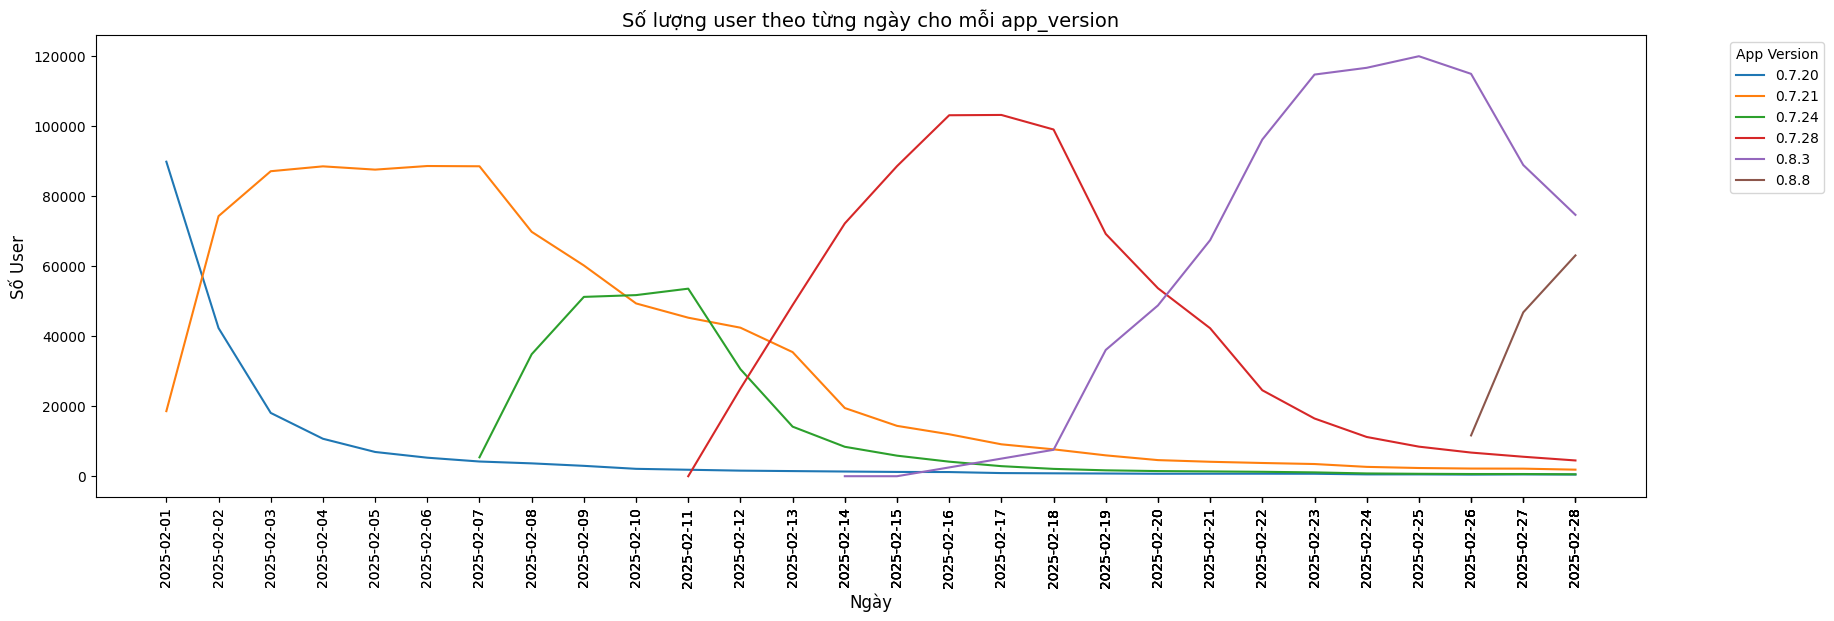

In [ ]:
#DAU đối với những app còn hoạt động của IOS
query = """
select version, date_par, count(distinct user_pseudo_id) as num_user_active
from `royal-hexa-in-house.pixon_data_science.003_mock`
where version in ('0.8.8', '0.7.20', '0.7.24', '0.7.28', '0.8.3', '0.7.21')
and event_name = 'user_engagement' and platform = 'ANDROID'
group by version, date_par order by date_par
"""
user_per_appversion_date_ANDROID = client.query(query).to_dataframe()
# Vẽ biểu đồ
plt.figure(figsize=(20, 6))
sns.lineplot(data=user_per_appversion_date_ANDROID, x="date_par", y="num_user_active", hue="version", palette="tab10")

# Tùy chỉnh biểu đồ
plt.xlabel("Ngày", fontsize=12)
plt.ylabel("Số User", fontsize=12)
plt.title("Số lượng user theo từng ngày cho mỗi app_version", fontsize=14)

# Xoay dọc các nhãn x để hiển thị hết giá trị
plt.xticks(rotation=90)
plt.gca().set_xticks(user_per_appversion_date_ANDROID["date_par"])
# Hiển thị legend ở vị trí bên phải
plt.legend(title="App Version", bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiển thị biểu đồ
plt.show()

Như vật đối với Android, ta sẽ đánh giá 3 app_version chính là: 0.7.21, 0.7.24, 0.7.28, 0.8.3
Cụ thể:
- 0.7.21: ra mắt từ ngày 1
- 0.7.24: ra mắt từ ngày 7
- 0.7.28: ra mắt từ ngày 11
- 0.8.3: ra mắt từ ngày 14

# Phân tích, đánh giá appversion

## IOS

- 0.7.9 từ ngày 04-11.

- 0.7.12 từ ngày 13-20.

- 0.7.13 từ ngày 21-28

In [ ]:
query = """
select version, country, count(distinct user_pseudo_id) as num_user
from `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE platform = 'IOS' and version in ('0.7.7', '0.7.13', '0.7.12', '0.7.9')
group by version, country order by num_user desc
"""
user_per_appversion_country_IOS = client.query(query).to_dataframe()
user_per_appversion_country_IOS

,version,country,num_user
0,0.7.9,United States,102749
1,0.7.12,United States,82492
2,0.7.13,United States,67767
3,0.7.7,United States,63200
4,0.7.9,Brazil,32231
5,0.7.9,Indonesia,32020
6,0.7.13,Brazil,31612
7,0.7.12,Brazil,29451
8,0.7.12,Indonesia,26143
9,0.7.9,Japan,26099


Do cả 4 version đều có lượng user đông nhất đến từ US, cũng là tệp user chất lượng nhất, nên để đảm bảo đánh giá trên được 1 tệp giống nhau, ta chỉ lọc ra country = US

### Xu hướng user mới

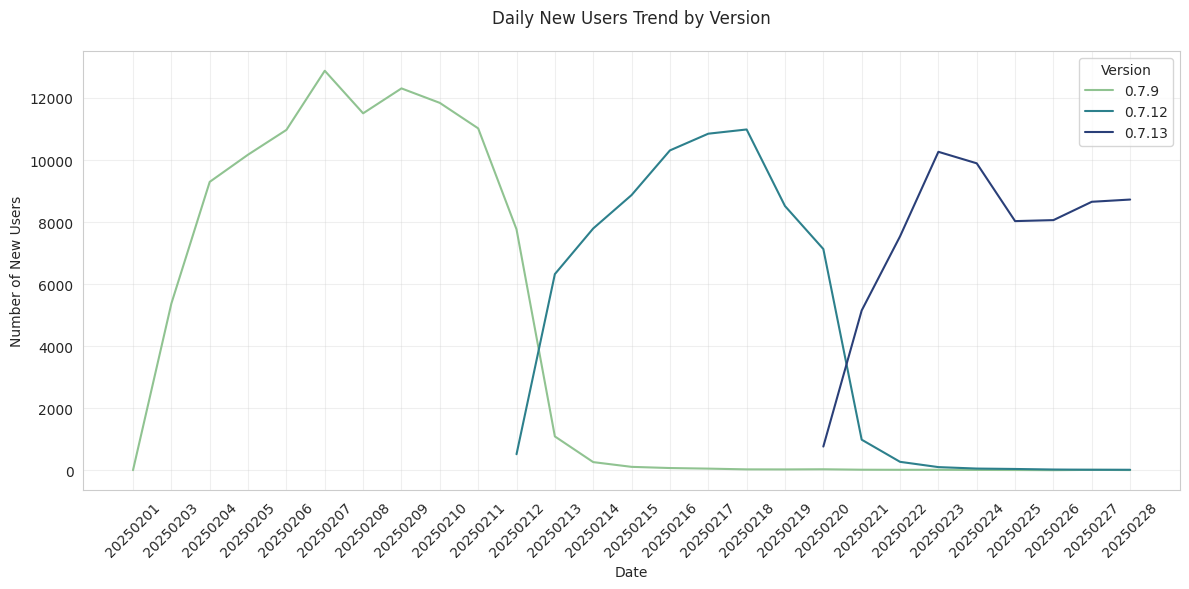

In [ ]:
# Query to get new users by date
new_users_query = """
SELECT
    event_date,
    version,
    COUNT(DISTINCT CASE WHEN event_name = 'first_open' THEN user_pseudo_id END) as new_users
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE platform = 'IOS'
	AND version IN ('0.7.13', '0.7.12', '0.7.9')
GROUP BY event_date, version
ORDER BY event_date;
"""

new_users = client.query(new_users_query).to_dataframe()

# Set the style
sns.set_style("whitegrid")

# Get 3 distinctive colors from crest colormap
crest_colors = sns.color_palette("crest", n_colors=12)
selected_colors = [crest_colors[0], crest_colors[6], crest_colors[-1]]  # First, middle and last colors

# Create the visualization
plt.figure(figsize=(12, 6))

# Create a dictionary mapping versions to colors
versions = new_users['version'].unique()
color_dict = dict(zip(versions, selected_colors))

# Plot each version with a specific color
for version, color in color_dict.items():
    version_data = new_users[new_users['version'] == version]
    plt.plot(version_data['event_date'], version_data['new_users'], label=version, color=color)

# Customize the plot
plt.title('Daily New Users Trend by Version', pad=20)
plt.xlabel('Date')
plt.ylabel('Number of New Users')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend(title='Version')
plt.tight_layout()

# Show the plot
plt.show()

### So sánh cohort giữa 3 app version IOS


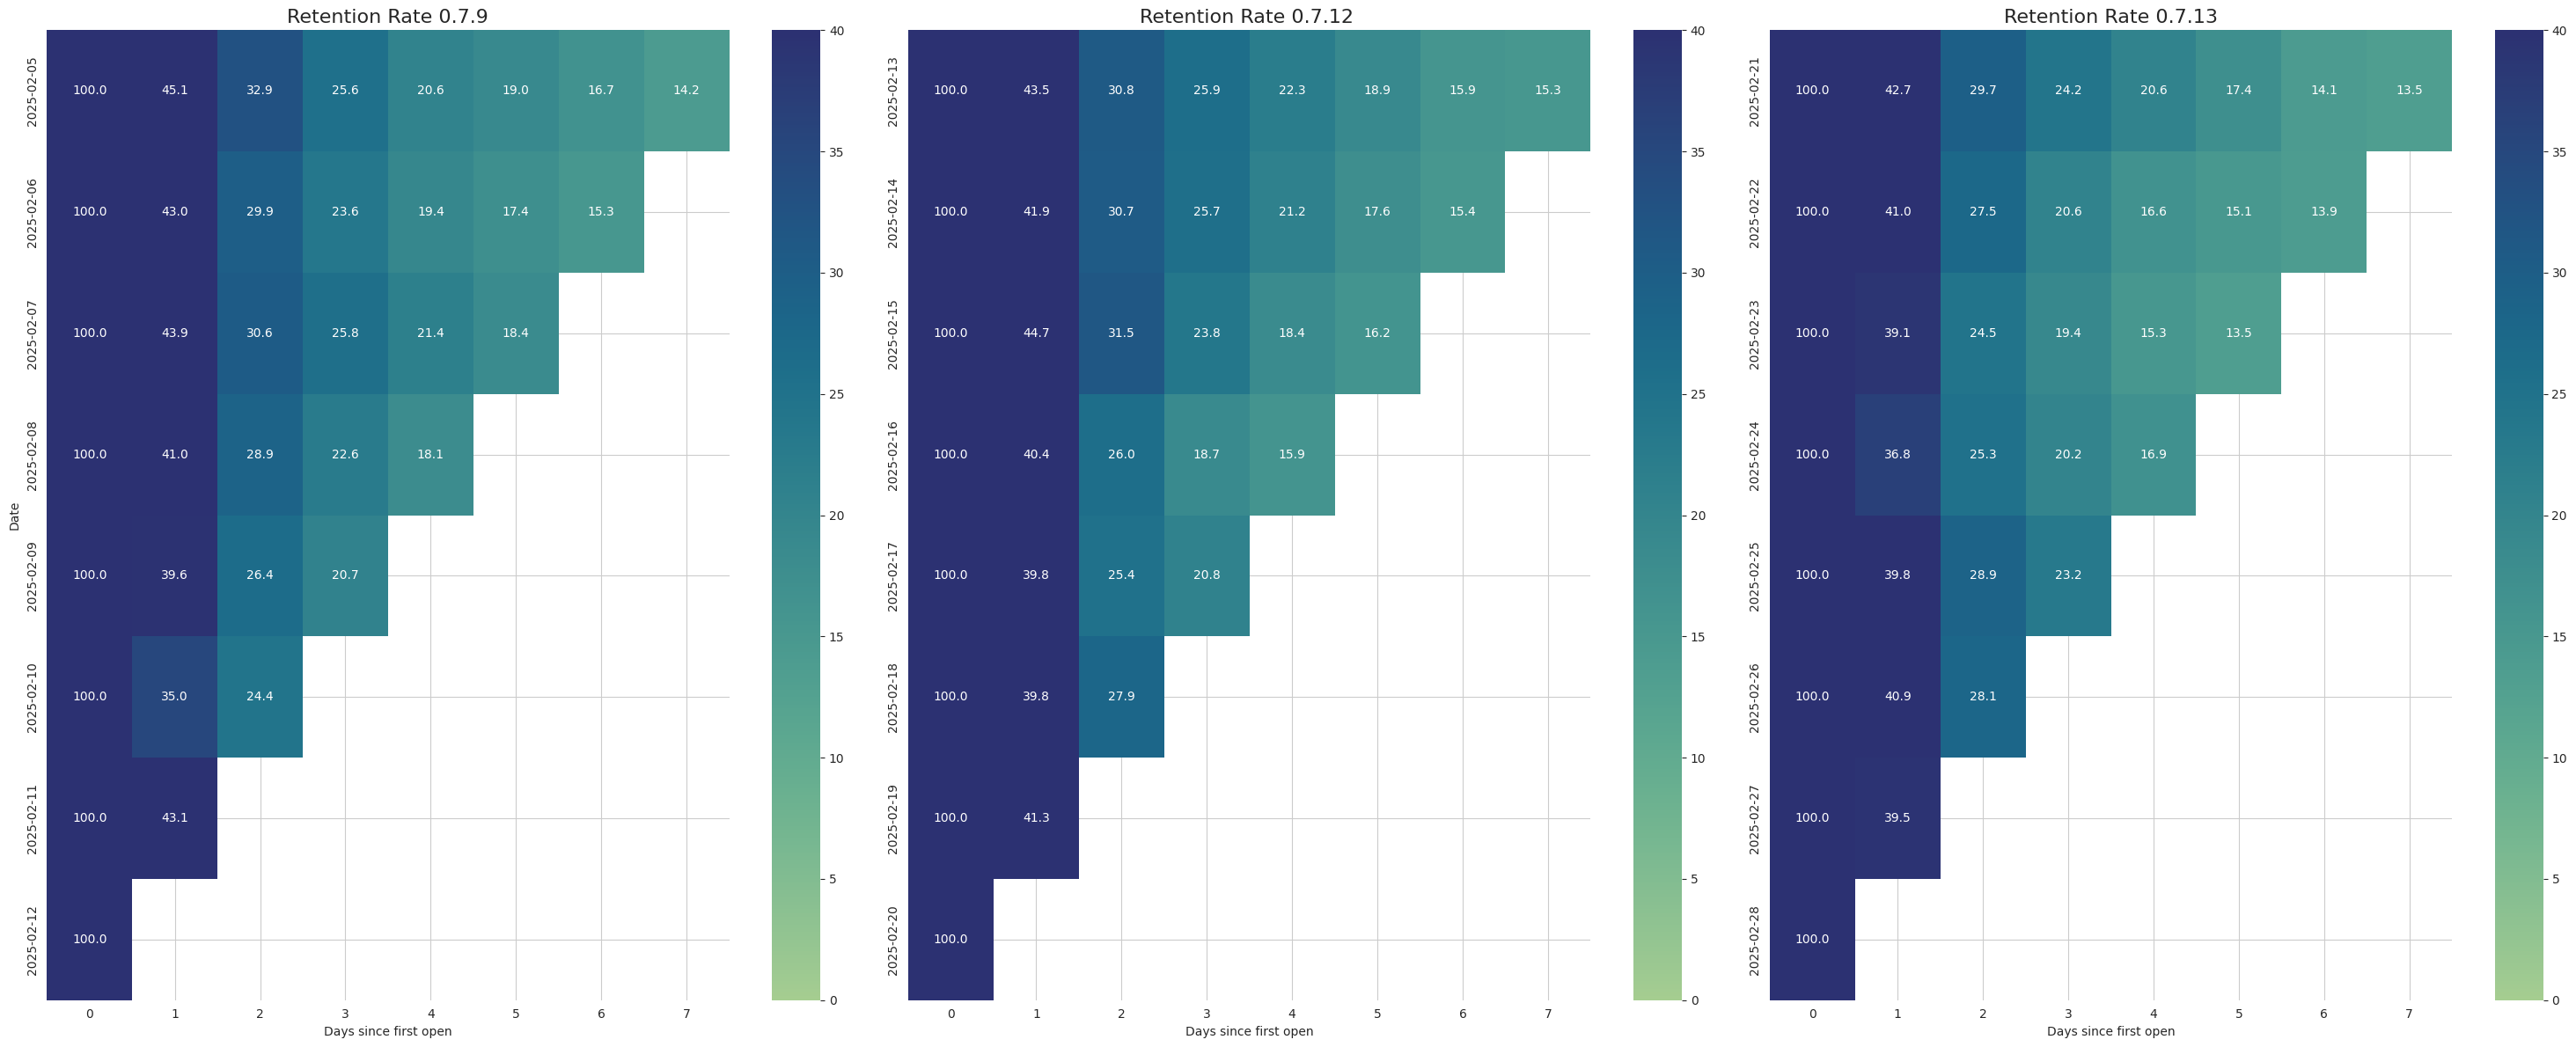

In [ ]:
query1 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-05' and '2025-02-12'
    and version = '0.7.9' and country = 'United States' and platform = 'IOS'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-05' and '2025-02-12' and version = '0.7.9' and country = 'United States' and platform = 'IOS') e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""

query2 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-13' and '2025-02-20'
    and version = '0.7.12' and country = 'United States' and platform = 'IOS'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-13' and '2025-02-20'  and version = '0.7.12' and country = 'United States' and platform = 'IOS' ) e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""


query3 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-21' and '2025-02-28'
    and version = '0.7.13' and country = 'United States' and platform = 'IOS'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-21' and '2025-02-28'  and version = '0.7.13' and country = 'United States' and platform = 'IOS' ) e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""
retention_0_7_9 = client.query(query1).to_dataframe()
retention_0_7_12 = client.query(query2).to_dataframe()
retention_0_7_13 = client.query(query3).to_dataframe()

#pivot
retention_0_7_9_pivot = retention_0_7_9.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)
retention_0_7_12_pivot = retention_0_7_12.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)
retention_0_7_13_pivot = retention_0_7_13.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)


import matplotlib.pyplot as plt
import seaborn as sns

# Tạo figure với 3 subplot (1 hàng, 3 cột)
fig, axes = plt.subplots(1, 3, figsize=(30, 12))

# Heatmap cho phiên bản 1.29.5
sns.heatmap(data=retention_0_7_9_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[0])
axes[0].set_title("Retention Rate 0.7.9", fontsize=16)
axes[0].set_xlabel('Days since first open')
axes[0].set_ylabel('Date')

# Heatmap cho phiên bản 1.30
sns.heatmap(data=retention_0_7_12_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[1])
axes[1].set_title("Retention Rate 0.7.12 ", fontsize=16)
axes[1].set_xlabel('Days since first open')
axes[1].set_ylabel('')

# Heatmap cho phiên bản 1.35.2
sns.heatmap(data=retention_0_7_13_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[2])
axes[2].set_title("Retention Rate 0.7.13", fontsize=16)
axes[2].set_xlabel('Days since first open')
axes[2].set_ylabel('')

# Căn chỉnh layout để các heatmap không bị chồng lên nhau
plt.tight_layout()
plt.show()


### So sánh chỉ số playtime

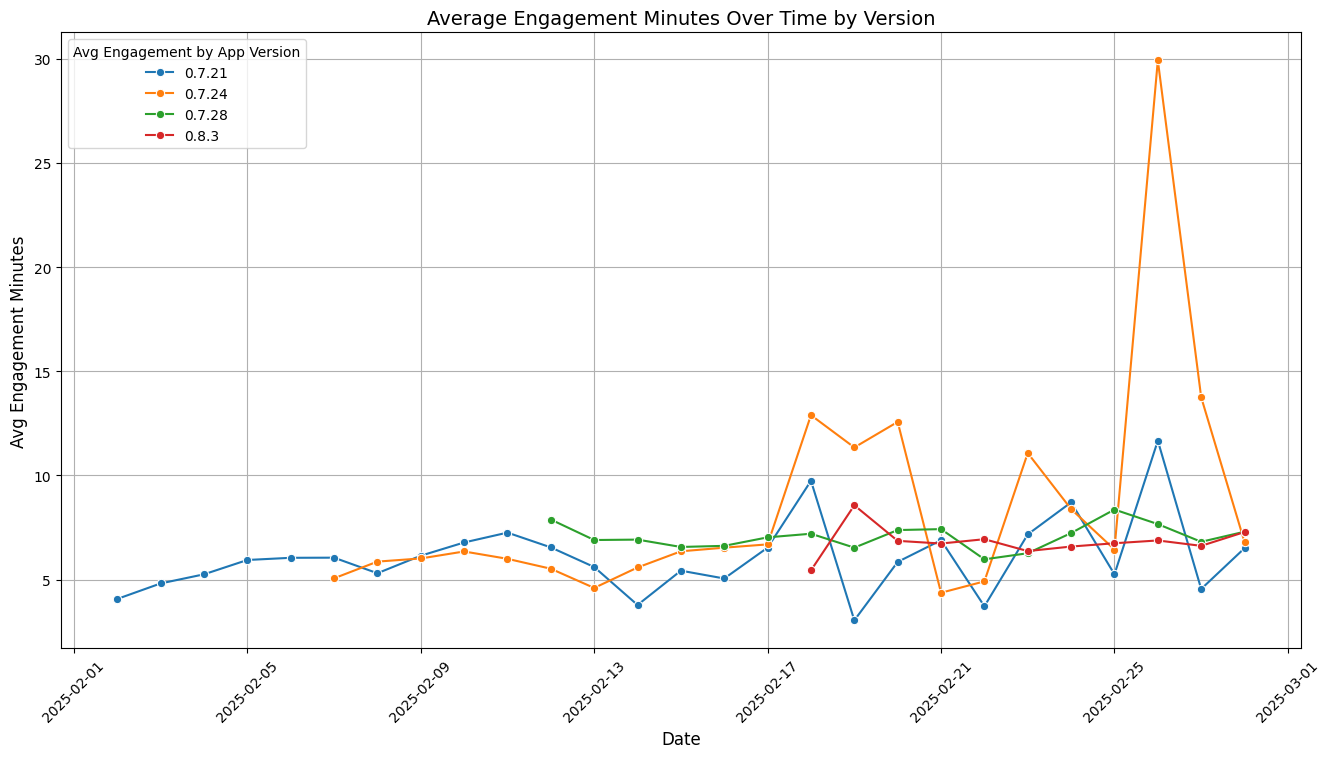

In [ ]:
query ="""
SELECT date_par,
       version,
       sum((SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'engagement_time_msec'))
       / count(distinct user_pseudo_id) --user active
       / 60000 AS avg_engage_minutes,
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'user_engagement'
AND version IN ('0.7.9', '0.7.12', '0.7.13') and country = 'United States' and platform = 'IOS'
AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
GROUP BY date_par, version
ORDER BY date_par;
"""
playtime = client.query(query).to_dataframe()
# Vẽ biểu đồ line chart với Seaborn
plt.figure(figsize=(16, 8))
sns.lineplot(data=playtime, x='date_par', y='avg_engage_minutes', hue='version', marker='o')

# Tùy chỉnh biểu đồ
plt.title("Average Engagement Minutes Over Time by Version", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Avg Engagement Minutes", fontsize=12)
plt.xticks(rotation=45)  # Xoay nhãn ngày cho dễ đọc
plt.legend(title="Avg Engagement by App Version")
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

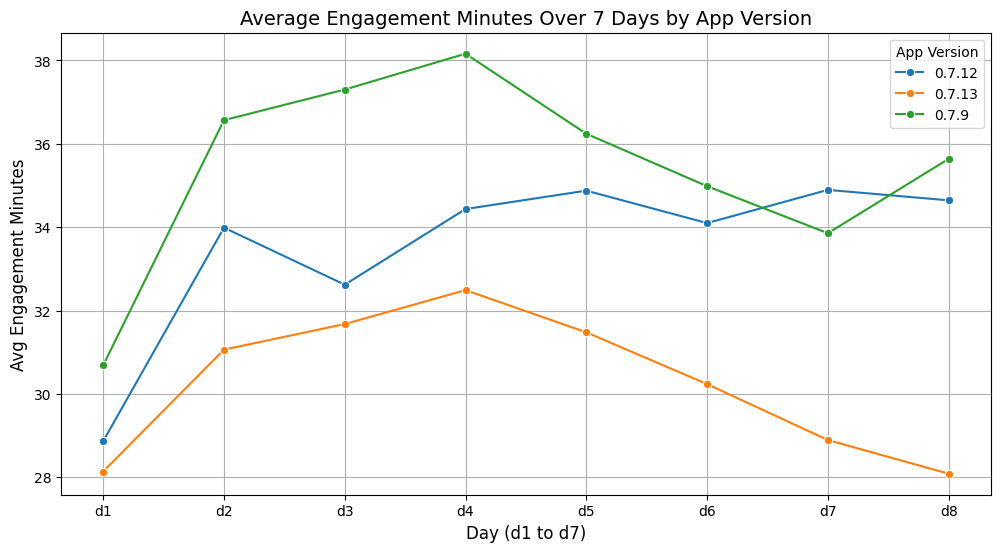

In [ ]:
query = """
WITH filtered_data AS (
    SELECT date_par,
           version,
           SUM((SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'engagement_time_msec'))
           / COUNT(DISTINCT user_pseudo_id) / 60000 AS avg_engage_minutes,
           CASE
               WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-04', DAY) + 1 AS STRING))
               WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
               WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-21', DAY) + 1 AS STRING))
           END AS day_label
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
      AND version IN ('0.7.9', '0.7.12', '0.7.13') and platform = 'IOS'
      AND country = 'United States' and platform = 'IOS'
      AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY date_par, version
)
SELECT day_label, version, AVG(avg_engage_minutes) AS avg_engage_minutes
FROM filtered_data
WHERE day_label IS NOT NULL
GROUP BY day_label, version
ORDER BY version, day_label;
"""

# Lấy dữ liệu từ BigQuery
playtime = client.query(query).to_dataframe()

# Vẽ biểu đồ line chart với Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=playtime, x='day_label', y='avg_engage_minutes', hue='version', marker='o')

# Tùy chỉnh biểu đồ
plt.title("Average Engagement Minutes Over 7 Days by App Version", fontsize=14)
plt.xlabel("Day (d1 to d7)", fontsize=12)
plt.ylabel("Avg Engagement Minutes", fontsize=12)
plt.xticks(rotation=0)  # Xoay nhãn ngày cho dễ đọc
plt.legend(title="App Version")
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


Avg của 0.7.9 và 0.7.12 khá ngang nhau; 0.7.13 có xu hướng thấp hơn 2 version kia

### Các chỉ số liên quan game play

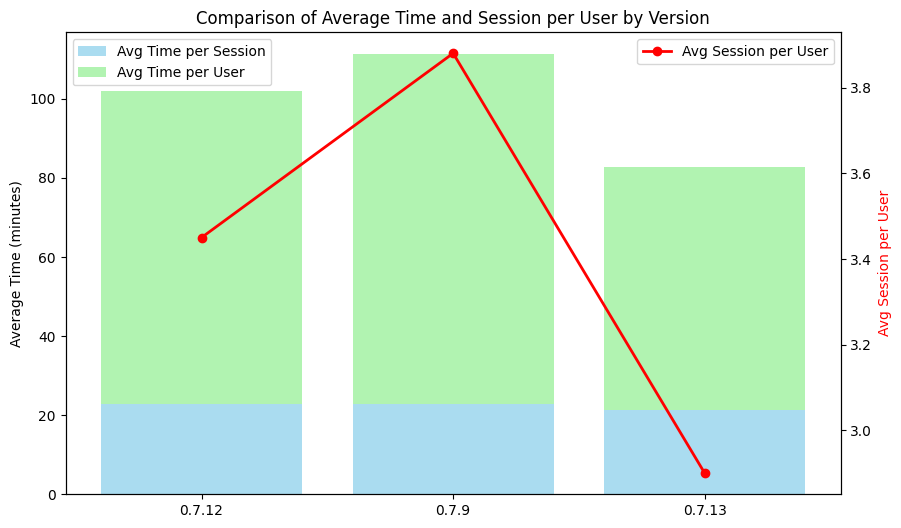

In [6]:
query = """
SELECT
  version,
   COUNT(DISTINCT CASE WHEN ep.key = 'ga_session_id' THEN ep.value.int_value END) AS total_session,
  SUM(CASE WHEN ep.key = 'engagement_time_msec' THEN ep.value.int_value END) AS total_engagement_time,
  COUNT(DISTINCT user_pseudo_id) AS total_users,
  ROUND((SUM(CASE WHEN ep.key = 'engagement_time_msec' THEN ep.value.int_value END) / COUNT(DISTINCT CASE WHEN ep.key = 'ga_session_id' THEN ep.value.int_value END)/60000), 2) AS avg_time_per_session,
  ROUND((SUM(CASE WHEN ep.key = 'engagement_time_msec' THEN ep.value.int_value END) / COUNT(DISTINCT user_pseudo_id)/60000), 2) AS avg_time_per_user,
  ROUND(COUNT(DISTINCT CASE WHEN ep.key = 'ga_session_id' THEN ep.value.int_value END) / COUNT(DISTINCT user_pseudo_id), 2) AS avg_session_per_user
FROM `royal-hexa-in-house.pixon_data_science.003_mock`,
UNNEST(event_params) AS ep
WHERE event_name = 'user_engagement'
  AND platform = 'IOS' AND version IN ('0.7.9', '0.7.12', '0.7.13') AND country = 'United States'
  AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
GROUP BY version
ORDER BY total_users DESC
"""

playtime = client.query(query).to_dataframe()

import pandas as pd
import matplotlib.pyplot as plt


# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(10, 6))

# Vẽ stacked column chart
ax1.bar(playtime['version'], playtime['avg_time_per_session'], label='Avg Time per Session', color='skyblue', alpha=0.7)
ax1.bar(playtime['version'], playtime['avg_time_per_user'], bottom=playtime['avg_time_per_session'], label='Avg Time per User', color='lightgreen', alpha=0.7)

# Thiết lập trục y cho cột
ax1.set_ylabel('Average Time (minutes)', color='black')
ax1.set_title('Comparison of Average Time and Session per User by Version')
ax1.legend(loc='upper left')

# Tạo trục y thứ hai cho line chart
ax2 = ax1.twinx()
ax2.plot(playtime['version'], playtime['avg_session_per_user'], color='red', marker='o', label='Avg Session per User', linewidth=2)
ax2.set_ylabel('Avg Session per User', color='red')
ax2.legend(loc='upper right')

# Hiển thị biểu đồ
plt.show()


### ARPU

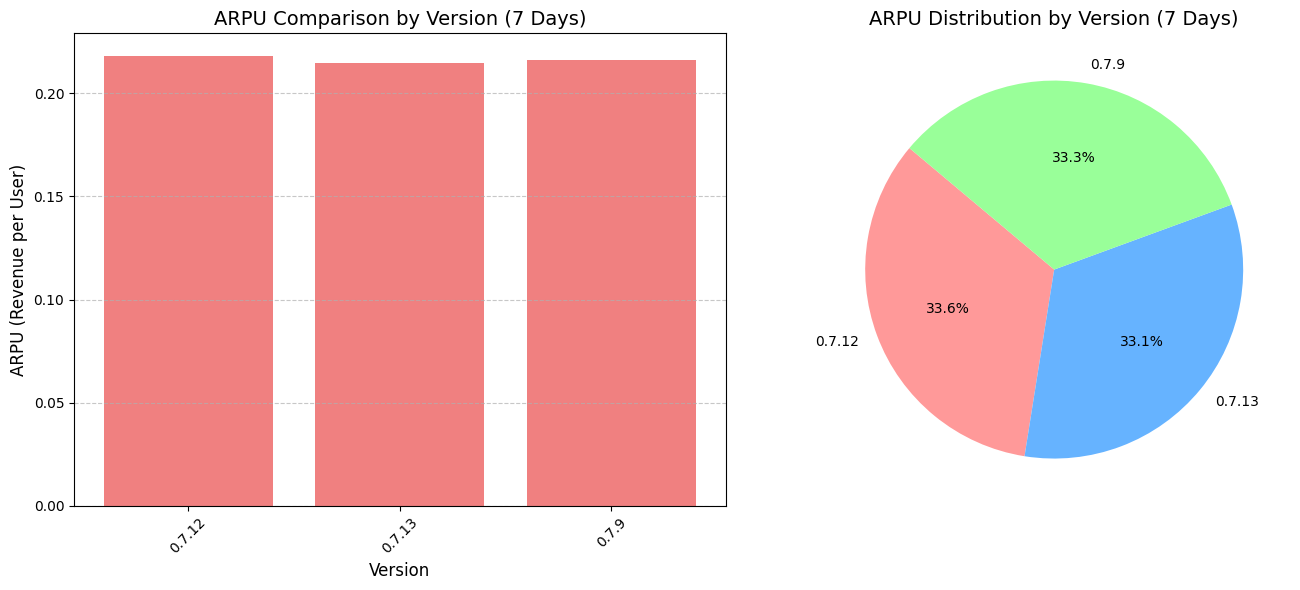

In [26]:
query = """
WITH user_data AS (
    SELECT version,
           CASE
               WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN '0.7.9'
               WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN '0.7.12'
               WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN '0.7.13'
           END AS version_group,
           COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
      AND version IN ('0.7.9', '0.7.12', '0.7.13')
      AND country = 'United States'  and platform = 'IOS'
      AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, version_group
),
iap AS (
    SELECT version,
           CASE
               WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN '0.7.9'
               WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN '0.7.12'
               WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN '0.7.13'
           END AS version_group,
           SUM(event_value_in_usd) AS revenue_from_iap
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
      AND version IN ('0.7.9', '0.7.12', '0.7.13')
      AND country = 'United States'  and platform = 'IOS'
      AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, version_group
),
ads AS (
    SELECT version,
           CASE
               WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN '0.7.9'
               WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN '0.7.12'
               WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN '0.7.13'
           END AS version_group,
           SUM((SELECT value.double_value FROM UNNEST(event_params) WHERE key = 'value')) AS revenue_from_ad
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ad_impression'
      AND version IN ('0.7.9', '0.7.12', '0.7.13')  and platform = 'IOS'
      AND country = 'United States'
      AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, version_group
)
SELECT user_data.version_group AS version,
       revenue_from_iap + revenue_from_ad AS total_revenue,
       num_user,
       (revenue_from_iap + revenue_from_ad) / num_user AS ARPU
FROM user_data
JOIN iap ON user_data.version_group = iap.version_group
JOIN ads ON user_data.version_group = ads.version_group
ORDER BY version;
"""

# Lấy dữ liệu từ BigQuery
arpu_data = client.query(query).to_dataframe()

# Tạo figure với 2 subplot (1 hàng, 2 cột)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Vẽ biểu đồ cột so sánh ARPU
axes[0].bar(arpu_data['version'], arpu_data['ARPU'], color='lightcoral')
axes[0].set_title('ARPU Comparison by Version (7 Days)', fontsize=14)
axes[0].set_xlabel('Version', fontsize=12)
axes[0].set_ylabel('ARPU (Revenue per User)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Vẽ biểu đồ pie thể hiện tỷ lệ ARPU của từng phiên bản
axes[1].pie(arpu_data['ARPU'], labels=arpu_data['version'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
axes[1].set_title('ARPU Distribution by Version (7 Days)', fontsize=14)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

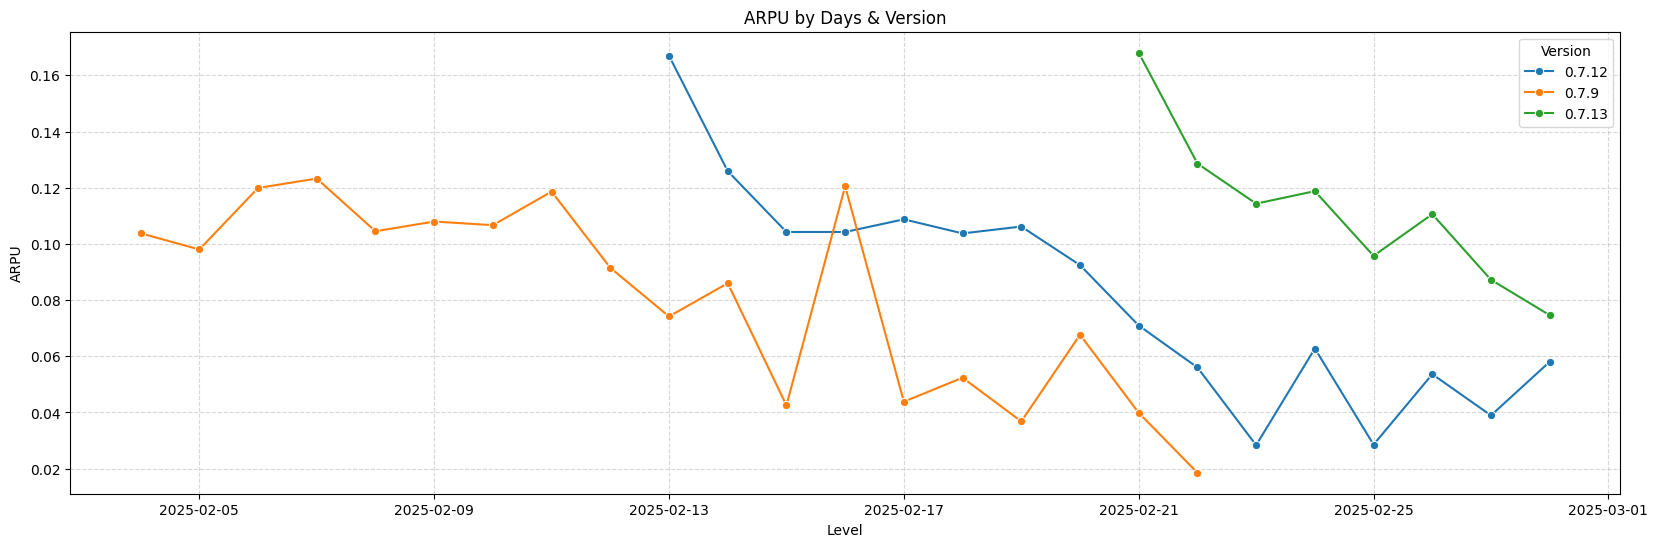

In [ ]:
QUERY = """-- Rev from iap per day
WITH iap AS (
    SELECT
        date_par,
        version,
        SUM(event_value_in_usd) AS revenue_from_iap_InUSD
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, date_par
),
ads AS (
    SELECT
        version,
        date_par,
        SUM(value) AS revenue_from_ad
    FROM (
        SELECT
            version,
            date_par,
            COALESCE((SELECT value.double_value FROM UNNEST(event_params) WHERE KEY = 'value'), 0) AS value
        FROM `royal-hexa-in-house.pixon_data_science.003_mock`
        WHERE event_name = 'ad_impression'
            AND date_par >= '2024-06-15'
            AND version IN ('0.7.9', '0.7.12', '0.7.13')
            AND platform = 'IOS'
            AND country = 'United States'
            AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    )
    GROUP BY version, date_par
),
user AS (
    SELECT
        version,
        date_par,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND date_par >= '2024-06-15'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, date_par
)
SELECT
    user.version,
    user.date_par,
    (COALESCE(revenue_from_iap_InUSD, 0) + COALESCE(revenue_from_ad, 0)) / NULLIF(num_user, 0) AS ARPU
FROM iap join ads on iap.version = ads.version and iap.date_par = ads.date_par
 join user on user.version = ads.version and user.date_par = ads.date_par
"""
ARPU_by_days = client.query(QUERY).to_dataframe()

# Vẽ
plt.figure(figsize=(20, 6))
sns.lineplot(data= ARPU_by_days, x="date_par", y="ARPU", hue="version", marker="o")

plt.title("ARPU by Days & Version")
plt.xlabel("Level")
plt.ylabel("ARPU")
plt.legend(title="Version")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

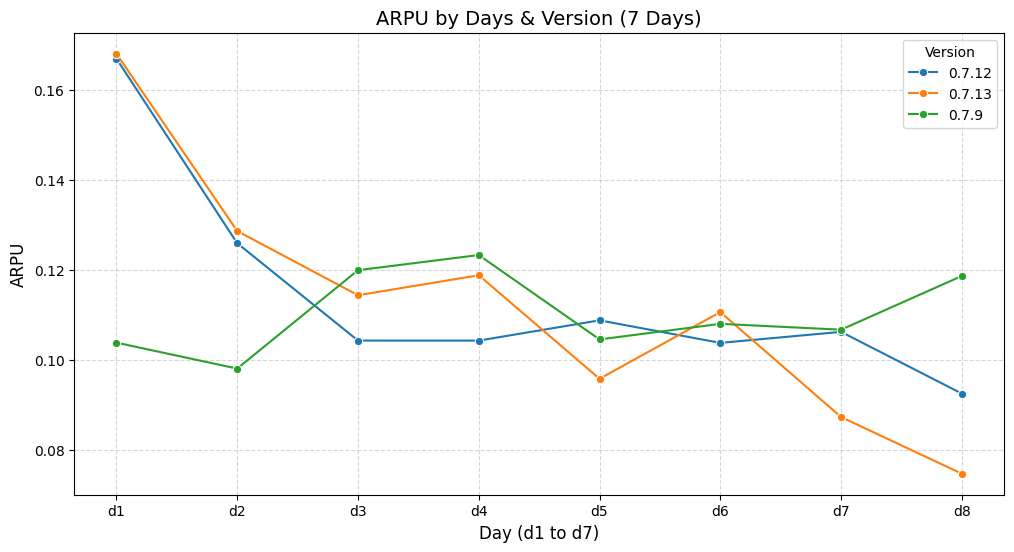

In [ ]:
QUERY = """
WITH iap AS (
    SELECT
        version,
        CASE
            WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-04', DAY) + 1 AS STRING))
            WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
            WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-21', DAY) + 1 AS STRING))
        END AS day_label,
        SUM(event_value_in_usd) AS revenue_from_iap
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, day_label
),
ads AS (
    SELECT
        version,
        CASE
            WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-04', DAY) + 1 AS STRING))
            WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
            WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-21', DAY) + 1 AS STRING))
        END AS day_label,
        SUM((SELECT value.double_value FROM UNNEST(event_params) WHERE key = 'value')) AS revenue_from_ad
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ad_impression'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')  AND platform = 'IOS'  AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, day_label
),
user AS (
    SELECT
        version,
        CASE
            WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-04', DAY) + 1 AS STRING))
            WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
            WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-21', DAY) + 1 AS STRING))
        END AS day_label,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, day_label
)
SELECT
    user.version,
    user.day_label,
    (COALESCE(revenue_from_iap, 0) + COALESCE(revenue_from_ad, 0)) / NULLIF(num_user, 0) AS ARPU
FROM user
LEFT JOIN iap ON user.version = iap.version AND user.day_label = iap.day_label
LEFT JOIN ads ON user.version = ads.version AND user.day_label = ads.day_label
WHERE user.day_label IS NOT NULL
ORDER BY version, day_label;
"""

# Lấy dữ liệu từ BigQuery
ARPU_by_days = client.query(QUERY).to_dataframe()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.lineplot(data=ARPU_by_days, x="day_label", y="ARPU", hue="version", marker="o")

plt.title("ARPU by Days & Version (7 Days)", fontsize=14)
plt.xlabel("Day (d1 to d7)", fontsize=12)
plt.ylabel("ARPU", fontsize=12)
plt.legend(title="Version")
plt.xticks(rotation=0)  # Xoay nhãn ngày cho dễ đọc
plt.grid(True, linestyle="--", alpha=0.5)

# Hiển thị biểu đồ
plt.show()


### Rev from ads, iap

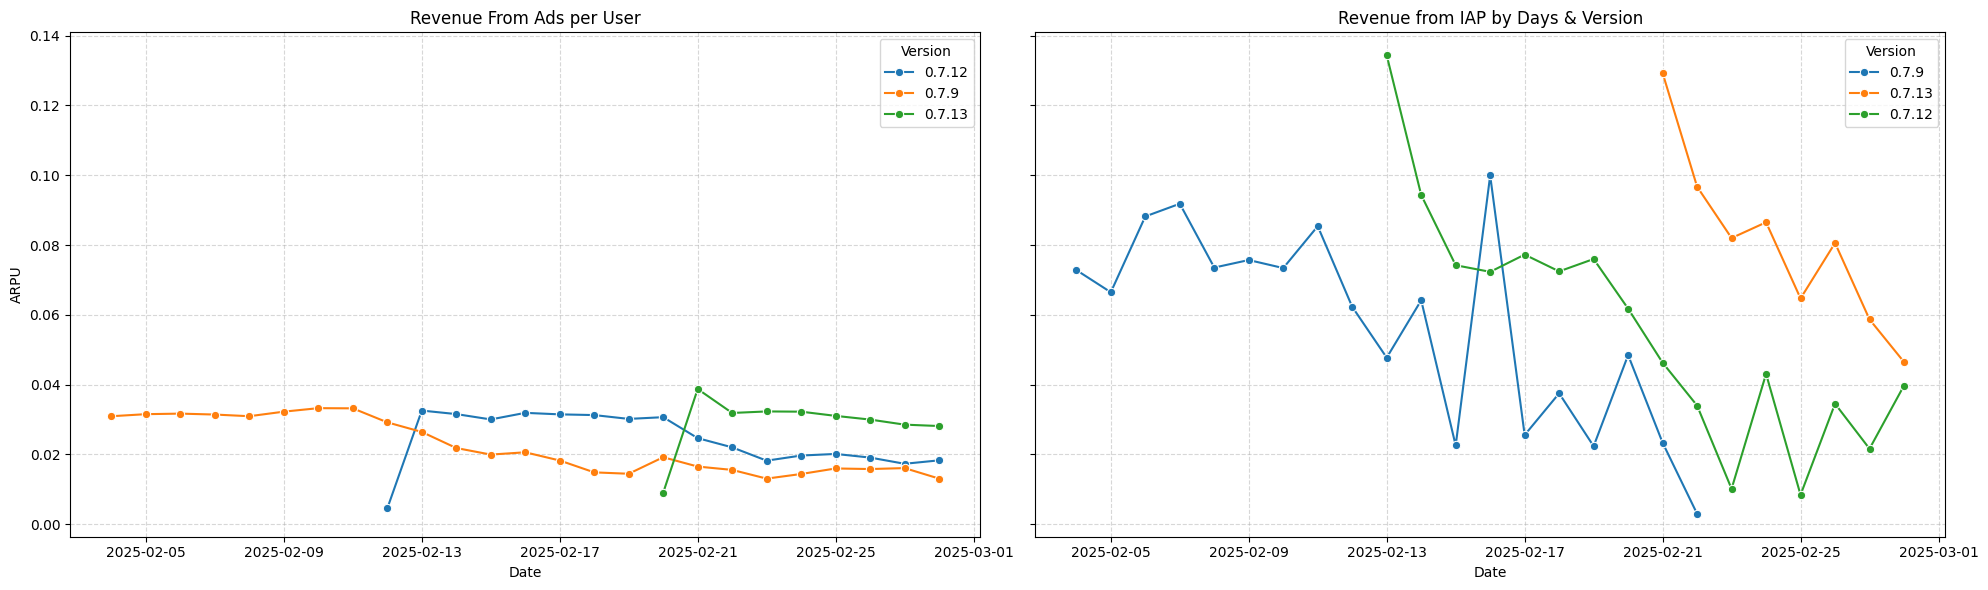

In [ ]:
QUERY1 = """
with ads as (
SELECT version,date_par, SUM(value) AS revenue_from_ad
FROM ( SELECT version,date_par, (SELECT value.double_value FROM UNNEST(event_params) WHERE KEY = 'value') AS value FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'ad_impression' AND version IN ('0.7.9', '0.7.12', '0.7.13')
AND platform = 'IOS'  AND country = 'United States'
AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )) group by version, date_par),
user as(
select version,date_par, count(distinct user_pseudo_id) as num_user
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'user_engagement' AND version IN ('0.7.9', '0.7.12', '0.7.13')
AND platform = 'IOS'  AND country = 'United States'
AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
group by version, date_par
)
select user.version,
     user.date_par,
     revenue_from_ad/num_user as rev_ad_per_user
from user join ads on user.version = ads.version and user.date_par = ads.date_par
"""
rev_from_ads_by_days = client.query(QUERY1).to_dataframe()

QUERY2 = """-- Rev from iap per day
with iap as(
select date_par, version, sum(event_value_in_usd) as revenue_from_iap_InUSD
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'in_app_purchase'AND version IN ('0.7.9', '0.7.12', '0.7.13')  AND platform = 'IOS'  AND country = 'United States'
AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
group by version, date_par),
user as(
select version,date_par, count(distinct user_pseudo_id) as num_user
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'user_engagement' AND version IN ('0.7.9', '0.7.12', '0.7.13')  AND platform = 'IOS'  AND country = 'United States'
AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
group by version, date_par
)
select user.version,
     user.date_par,
     revenue_from_iap_InUSD /num_user as rev_from_iap
from iap join user on iap.version = user.version and iap.date_par = user.date_par
"""
rev_from_iap_by_days = client.query(QUERY2).to_dataframe()
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 subplots (horizontally arranged)
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot 1: Revenue from ads per user
sns.lineplot(ax=axes[0], data=rev_from_ads_by_days, x="date_par", y="rev_ad_per_user", hue="version", marker="o")
axes[0].set_title("Revenue From Ads per User")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("ARPU")
axes[0].legend(title="Version")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot 2: Revenue from IAP by days & version
sns.lineplot(ax=axes[1], data=rev_from_iap_by_days, x="date_par", y="rev_from_iap", hue="version", marker="o")
axes[1].set_title("Revenue from IAP by Days & Version")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("ARPU")
axes[1].legend(title="Version")
axes[1].grid(True, linestyle="--", alpha=0.5)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()


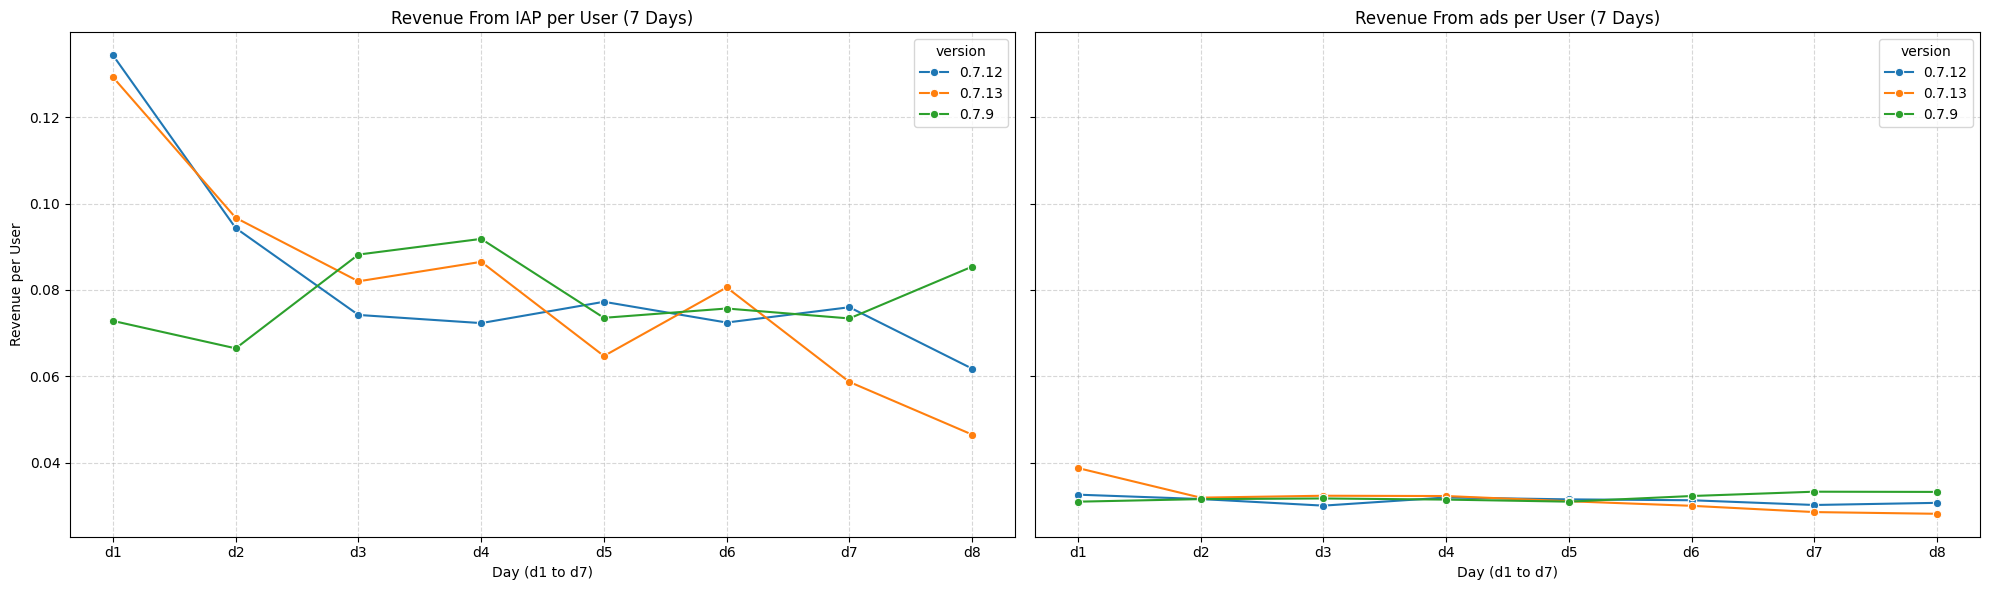

In [ ]:
QUERY1 = """
WITH ads AS (
    SELECT
        version,
        CASE
            WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-04', DAY) + 1 AS STRING))
            WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
            WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-21', DAY) + 1 AS STRING))
        END AS day_label,
        sum(event_value_in_usd) as revenue_from_iap_InUSD
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, day_label
),
user AS (
    SELECT
        version,
        CASE
            WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-04', DAY) + 1 AS STRING))
            WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
            WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-21', DAY) + 1 AS STRING))
        END AS day_label,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, day_label
)
SELECT
    user.version,
    user.day_label,
    COALESCE(revenue_from_iap_InUSD, 0) / NULLIF(num_user, 0) AS rev_iap_per_user
FROM user
LEFT JOIN ads ON user.version = ads.version AND user.day_label = ads.day_label
WHERE user.day_label IS NOT NULL
ORDER BY version, day_label;
"""
rev_from_iap_by_days = client.query(QUERY1).to_dataframe()

QUERY2 = """
WITH ads AS (
    SELECT
        version,
        CASE
            WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-04', DAY) + 1 AS STRING))
            WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
            WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-21', DAY) + 1 AS STRING))
        END AS day_label,
        SUM((SELECT value.double_value FROM UNNEST(event_params) WHERE key = 'value')) AS revenue_from_ad
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ad_impression'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, day_label
),
user AS (
    SELECT
        version,
        CASE
            WHEN version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-04', DAY) + 1 AS STRING))
            WHEN version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
            WHEN version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-21', DAY) + 1 AS STRING))
        END AS day_label,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version, day_label
)
SELECT
    user.version,
    user.day_label,
    COALESCE(revenue_from_ad, 0) / NULLIF(num_user, 0) AS rev_ad_per_user
FROM user
LEFT JOIN ads ON user.version = ads.version AND user.day_label = ads.day_label
WHERE user.day_label IS NOT NULL
ORDER BY version, day_label;
"""
rev_from_ads_by_days = client.query(QUERY2).to_dataframe()

# Vẽ biểu đồ line
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot 1: Revenue from Ads per User
sns.lineplot(ax=axes[0], data=rev_from_iap_by_days, x="day_label", y="rev_iap_per_user", hue="version", marker="o")
axes[0].set_title("Revenue From IAP per User (7 Days)")
axes[0].set_xlabel("Day (d1 to d7)")
axes[0].set_ylabel("Revenue per User")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot 2: Revenue from IAP per User
sns.lineplot(ax=axes[1], data=rev_from_ads_by_days, x="day_label", y="rev_ad_per_user", hue="version", marker="o")
axes[1].set_title("Revenue From ads per User (7 Days)")
axes[1].set_xlabel("Day (d1 to d7)")
axes[1].grid(True, linestyle="--", alpha=0.5)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

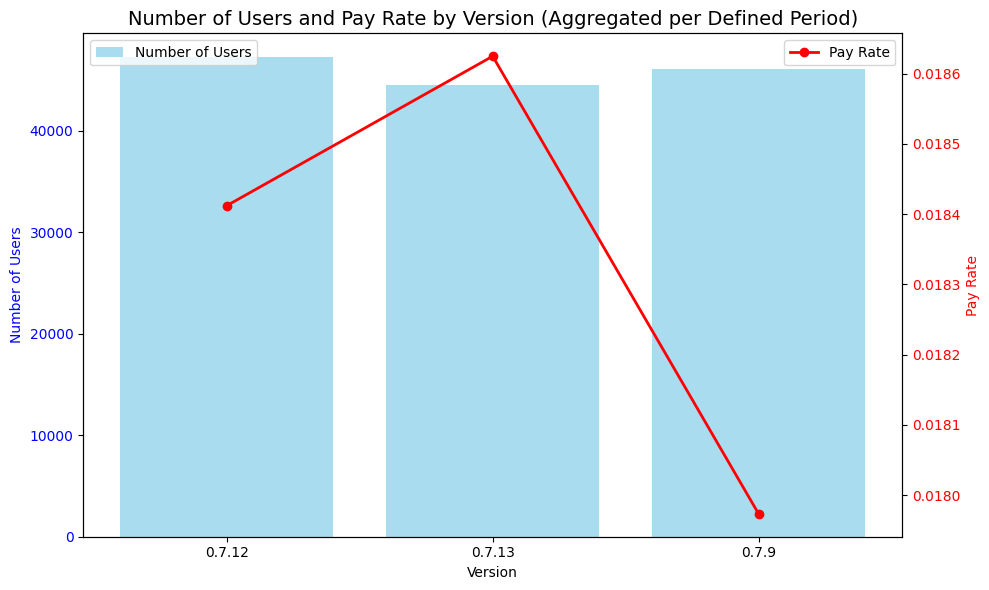

In [ ]:
# Tạo truy vấn SQL để tính Pay Rate tổng hợp theo phiên bản và khoảng thời gian được định nghĩa
query = """
WITH iap AS (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS user_iap
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28')
        )
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version
),
user AS (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28')
        )
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version
)
SELECT
    user.version,
    num_user,
    COALESCE(user_iap, 0) / NULLIF(num_user, 0) AS pay_rate
FROM user
LEFT JOIN iap ON user.version = iap.version
ORDER BY version;
"""

# Lấy dữ liệu từ BigQuery
pay_rate = client.query(query).to_dataframe()

# Tạo figure và các trục
fig, ax1 = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ cột cho số người dùng
ax1.bar(pay_rate['version'], pay_rate['num_user'], color='skyblue', alpha=0.7, label='Number of Users')
ax1.set_xlabel('Version')
ax1.set_ylabel('Number of Users', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Trục y thứ hai cho tỷ lệ thanh toán
ax2 = ax1.twinx()
ax2.plot(pay_rate['version'], pay_rate['pay_rate'], color='red', marker='o', linewidth=2, label='Pay Rate')
ax2.set_ylabel('Pay Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Tiêu đề và chú thích
plt.title('Number of Users and Pay Rate by Version (Aggregated per Defined Period)', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


### Kết hợp các chỉ số liên quan đến revenue

In [27]:
query = """
WITH iap AS (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS user_iap
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28')
        )
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version
),
user AS (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28')
        )
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version
),
ad_rw as (
  SELECT
  version,
  COUNT( user_pseudo_id) AS num_ads_rw
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ads_reward_complete'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    group by version
),
ad_rw_click as (
  SELECT
  version,
  COUNT( user_pseudo_id) AS num_ads_rw_click
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ads_reward_click'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    group by version
),
ads_shown as(
  SELECT
  version,
  COUNT( user_pseudo_id) AS ads_shown
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ad_impression'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    group by version
)
SELECT
    user.version,
    COALESCE(user_iap, 0) / NULLIF(num_user, 0) AS pay_rate,
    COALESCE(num_ads_rw, 0) / NULLIF(num_user, 0) AS ad_rw_complete_rate,
    COALESCE(num_ads_rw_click, 0) / NULLIF(num_user, 0) AS ads_rw_click_rate,
    COALESCE(ads_shown.ads_shown, 0) / NULLIF(num_user, 0) AS ad_impression_rate
FROM user
LEFT JOIN iap ON user.version = iap.version
join ad_rw on user.version = ad_rw.version
join ads_shown on user.version = ads_shown.version
join ad_rw_click on user.version = ad_rw_click.version
ORDER BY version;
"""

# Lấy dữ liệu từ BigQuery
pay_rate = client.query(query).to_dataframe()
pay_rate

,version,pay_rate,ad_rw_complete_rate,ads_rw_click_rate,ad_impression_rate
0,0.7.12,0.018412,5.511597,7.461483,584.200140
1,0.7.13,0.018625,4.988947,6.566714,519.736739
2,0.7.9,0.017973,5.336614,7.018407,602.969235


In [25]:
 query = """
 With rev_ad as(
  SELECT
  version,
   SUM((SELECT value.double_value FROM UNNEST(event_params) WHERE key = 'value')) AS revenue_from_ad
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ad_impression'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States' AND ((version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version
 ), rev_iap as (
  SELECT
        version,
        sum(event_value_in_usd) as revenue_from_iap_InUSD
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States' AND ((version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version
 ),
 user as (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND ((version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States')
  group by version)
 select
  user.version,
  rev_ad.revenue_from_ad,
  rev_iap.revenue_from_iap_InUSD,
  rev_ad.revenue_from_ad/user.num_user as rev_from_ad_per_user,
  rev_iap.revenue_from_iap_InUSD/user.num_user as rev_from_iap_per_user,
  user.num_user
 from user
 join rev_ad on user.version = rev_ad.version
 join rev_iap on user.version = rev_iap.version
 """
 rev= client.query(query).to_dataframe()
 rev

,version,revenue_from_ad,revenue_from_iap_InUSD,rev_from_ad_per_user,rev_from_iap_per_user,num_user
0,0.7.12,2970.005162,7339.243301,0.062855,0.155321,47252
1,0.7.9,2878.006837,7094.705217,0.062397,0.153818,46124
2,0.7.13,2778.649242,6786.152602,0.062426,0.152460,44511


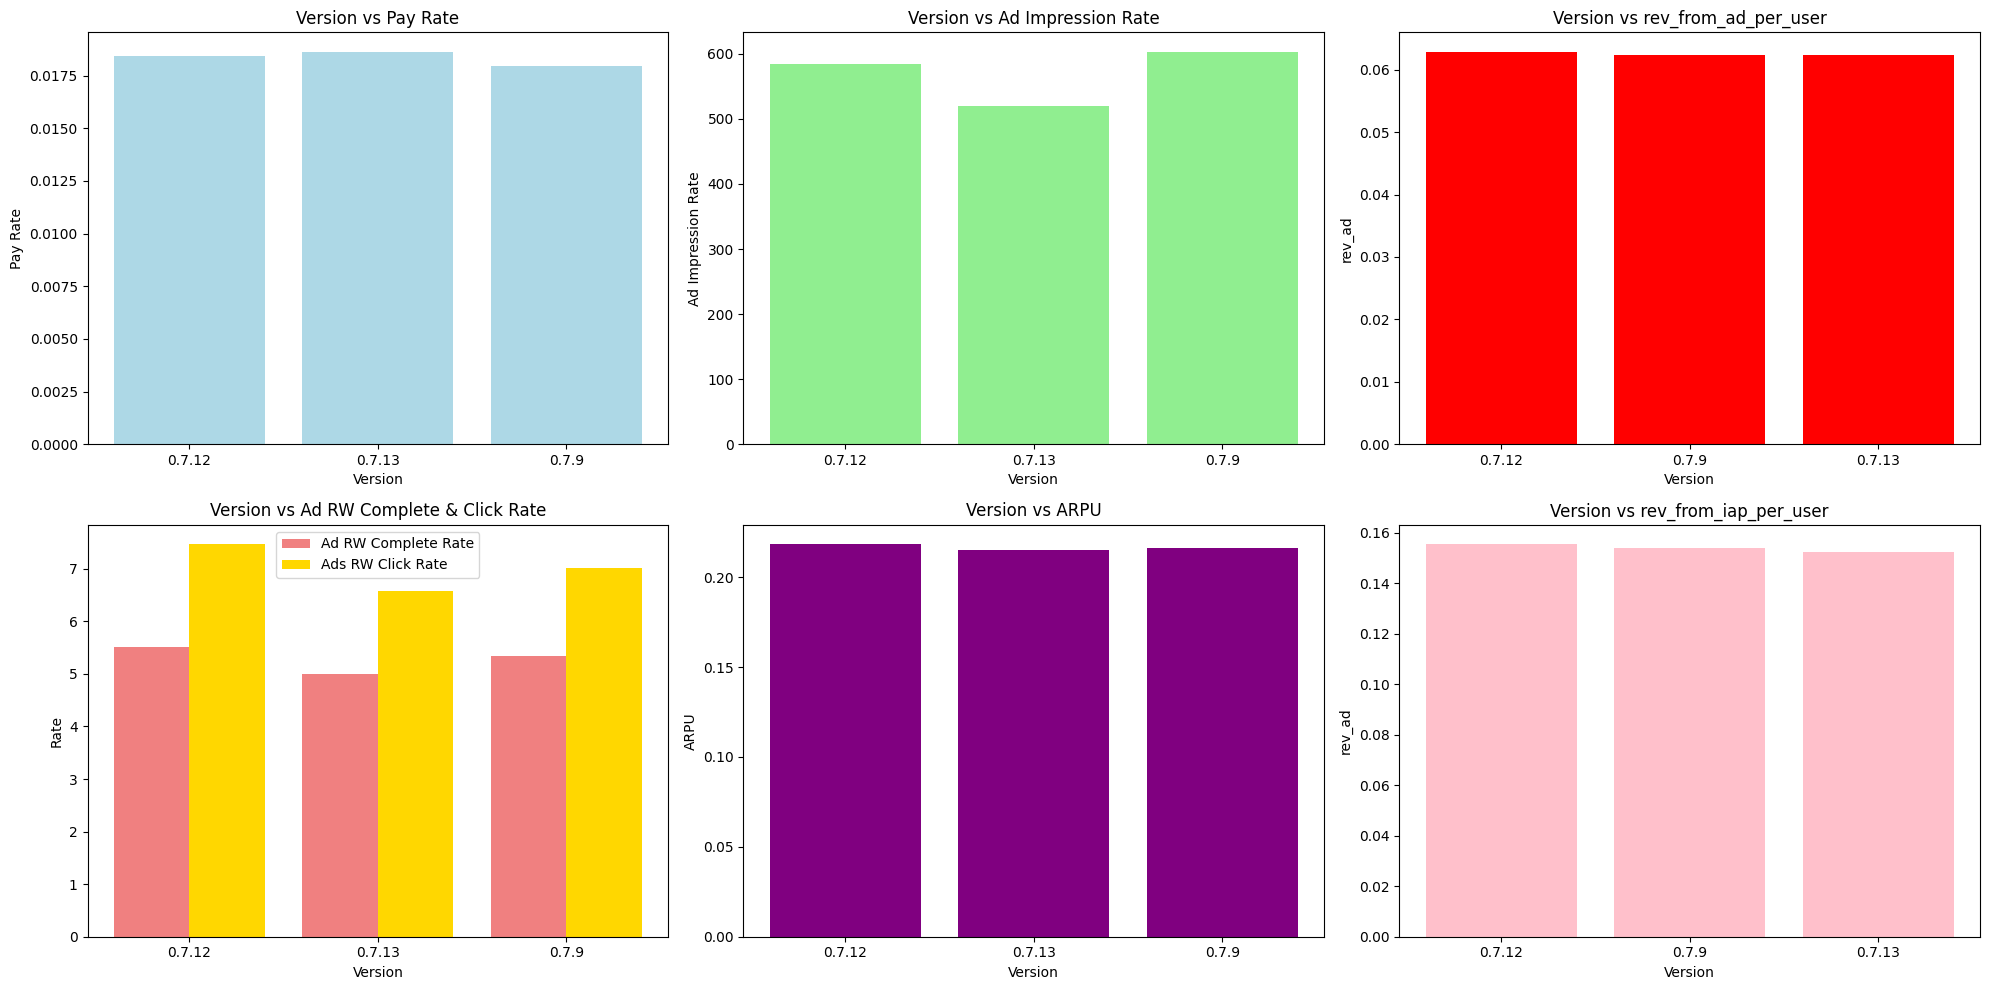

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Kết hợp hai bảng vào một DataFrame duy nhất
combined_data = pay_rate.merge(arpu_data[['version', 'ARPU']], on='version')

# Tạo figure với 4 subplots (2x2)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Biểu đồ 1: Version vs Pay Rate
axes[0, 0].bar(combined_data['version'], combined_data['pay_rate'], color='lightblue')
axes[0, 0].set_title('Version vs Pay Rate')
axes[0, 0].set_xlabel('Version')
axes[0, 0].set_ylabel('Pay Rate')

# Biểu đồ 2: Version vs Ad Impression Rate
axes[0, 1].bar(combined_data['version'], combined_data['ad_impression_rate'], color='lightgreen')
axes[0, 1].set_title('Version vs Ad Impression Rate')
axes[0, 1].set_xlabel('Version')
axes[0, 1].set_ylabel('Ad Impression Rate')

# Biểu đồ 3: Version vs Ad RW Complete Rate & Ads RW Click Rate
x = np.arange(len(combined_data['version']))  # Vị trí của các phiên bản
width = 0.4  # Độ rộng của mỗi cột
axes[1, 0].bar(x - width/2, combined_data['ad_rw_complete_rate'], width, label='Ad RW Complete Rate', color='lightcoral')
axes[1, 0].bar(x + width/2, combined_data['ads_rw_click_rate'], width, label='Ads RW Click Rate', color='gold')
axes[1, 0].set_title('Version vs Ad RW Complete & Click Rate')
axes[1, 0].set_xlabel('Version')
axes[1, 0].set_ylabel('Rate')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(combined_data['version'])
axes[1, 0].legend()

# Biểu đồ 4: Version vs ARPU
axes[1, 1].bar(combined_data['version'], combined_data['ARPU'], color='purple')
axes[1, 1].set_title('Version vs ARPU')
axes[1, 1].set_xlabel('Version')
axes[1, 1].set_ylabel('ARPU')

# Biểu đồ 5: Version vs ad_per_user
axes[0, 2].bar(rev['version'], rev['rev_from_ad_per_user'], color='red')
axes[0, 2].set_title('Version vs rev_from_ad_per_user')
axes[0, 2].set_xlabel('Version')
axes[0, 2].set_ylabel('rev_ad')

# Biểu đồ 6: Version vs ad_per_user
axes[1, 2].bar(rev['version'], rev['rev_from_iap_per_user'], color='pink')
axes[1, 2].set_title('Version vs rev_from_iap_per_user')
axes[1, 2].set_xlabel('Version')
axes[1, 2].set_ylabel('rev_ad')

# Tối ưu bố cục và hiển thị biểu đồ
plt.tight_layout()
plt.show()


### Level Churn

In [ ]:
query = """
SELECT
  SAFE_CAST(level AS STRING) AS level,
  version,
  COUNT(CASE WHEN event_name = 'start_level' THEN user_pseudo_id END) AS event_start,
  COUNT(CASE WHEN event_name = 'win_level'  THEN user_pseudo_id END) AS event_win,
  COUNT(CASE WHEN event_name = 'lose_level'  THEN user_pseudo_id END) AS event_lose,
  COUNT(DISTINCT CASE WHEN event_name = 'start_level' THEN user_pseudo_id END) AS user_start,
  COUNT(DISTINCT CASE WHEN event_name = 'win_level'  THEN user_pseudo_id END) AS user_win,
  COUNT(DISTINCT CASE WHEN event_name = 'lose_level'  THEN user_pseudo_id END) AS event_lose,
FROM
(
  SELECT
    user_pseudo_id,
    event_name,
    version,
    COALESCE(
      (SELECT SAFE_CAST(value.int_value AS STRING) FROM UNNEST(event_params) WHERE KEY = 'level'),
      (SELECT value.string_value FROM UNNEST(event_params) WHERE KEY = 'level')
    ) AS level
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name IN ('start_level', 'win_level','lose_level')
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
  AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
)
GROUP BY level, version
HAVING SAFE_CAST(level AS INT64) < 50
ORDER BY SAFE_CAST(level AS INT64);
"""

winrate = client.query(query).to_dataframe()
winrate

,level,version,event_start,event_win,event_lose,user_start,user_win,event_lose_1
0,1,0.7.12,38798,32733,638,35000,32308,535
1,1,0.7.13,30988,25496,654,27499,25121,514
2,1,0.7.9,50759,41995,920,45461,41426,815
3,2,0.7.13,30991,23414,1457,24742,23023,763
4,2,0.7.12,39525,30044,1767,31726,29494,943
...,...,...,...,...,...,...,...,...
142,48,0.7.13,4881,3785,2313,3326,3726,1634
143,48,0.7.12,5567,4409,2541,3893,4330,1927
144,49,0.7.12,7041,4282,1305,3911,4216,625
145,49,0.7.13,6850,3695,1687,3374,3636,535


In [ ]:
winrate['winrate'] = winrate['event_win'] / (winrate['event_win'] + winrate['event_lose'])
winrate['winrate_percent'] = winrate['winrate'] * 100
winrate_df = winrate.copy()
# Ensure that 'version' is treated as a string to match correctly
winrate_df['version'] = winrate_df['version'].astype(str)

# Convert 'level' to numeric, forcing any non-numeric entries to NaN
winrate_df['level'] = pd.to_numeric(winrate_df['level'], errors='coerce')

# Drop rows where level is NaN (caused by non-numeric levels)
winrate_df = winrate_df.dropna(subset=['level'])

# Create a dictionary mapping version to user_start of level 1
level_1_user_start = winrate_df[winrate_df['level'] == 1].set_index('version')['user_start'].to_dict()

# Map the dictionary to create the user_drop column
winrate_df['user_drop'] = winrate_df.apply(lambda row: row['user_start'] / level_1_user_start.get(str(row['version']), float('nan')), axis=1)
winrate_df

,level,version,event_start,event_win,event_lose,user_start,user_win,event_lose_1,winrate,winrate_percent,user_drop
0,1,0.7.12,38798,32733,638,35000,32308,535,0.980882,98.08816,1.000000
1,1,0.7.13,30988,25496,654,27499,25121,514,0.97499,97.499044,1.000000
2,1,0.7.9,50759,41995,920,45461,41426,815,0.978562,97.856227,1.000000
3,2,0.7.13,30991,23414,1457,24742,23023,763,0.941418,94.141772,0.899742
4,2,0.7.12,39525,30044,1767,31726,29494,943,0.944453,94.445318,0.906457
...,...,...,...,...,...,...,...,...,...,...,...
142,48,0.7.13,4881,3785,2313,3326,3726,1634,0.620695,62.069531,0.120950
143,48,0.7.12,5567,4409,2541,3893,4330,1927,0.634388,63.438849,0.111229
144,49,0.7.12,7041,4282,1305,3911,4216,625,0.766422,76.642205,0.111743
145,49,0.7.13,6850,3695,1687,3374,3636,535,0.686548,68.654775,0.122695


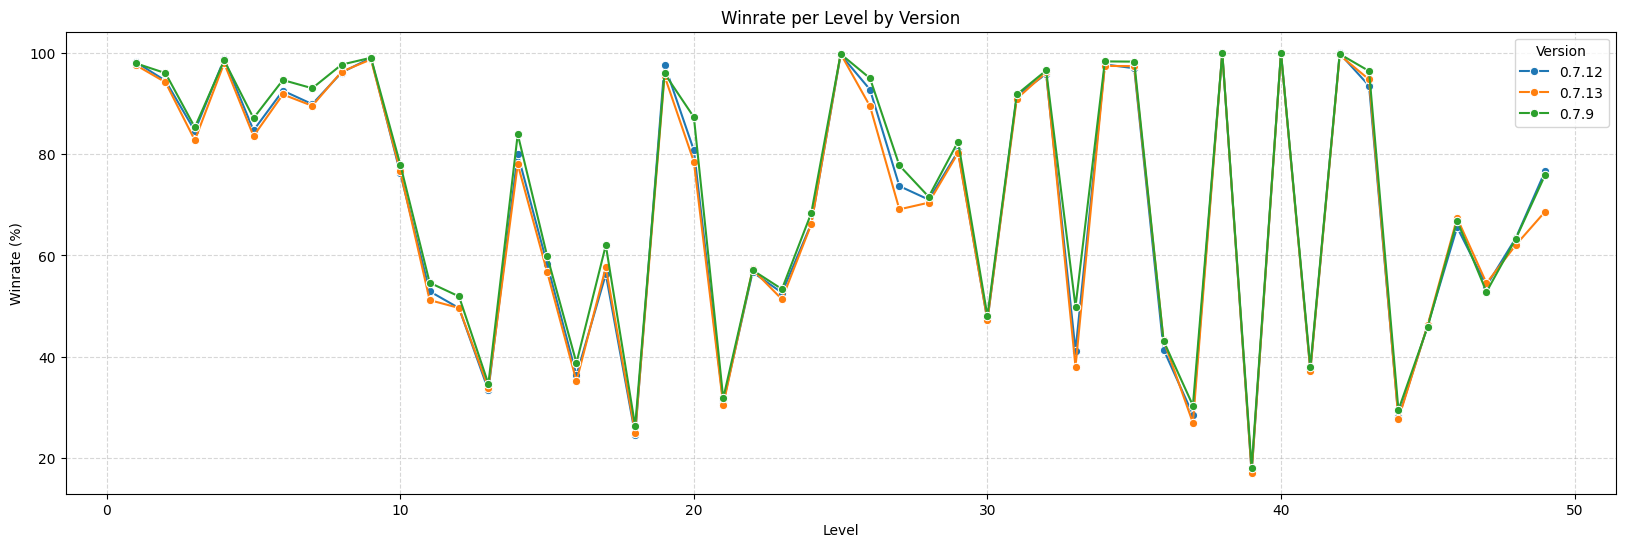

In [ ]:
# Vẽ
plt.figure(figsize=(20, 6))
sns.lineplot(data=winrate_df, x="level", y="winrate_percent", hue="version", marker="o")

plt.title("Winrate per Level by Version")
plt.xlabel("Level")
plt.ylabel("Winrate (%)")
plt.legend(title="Version")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

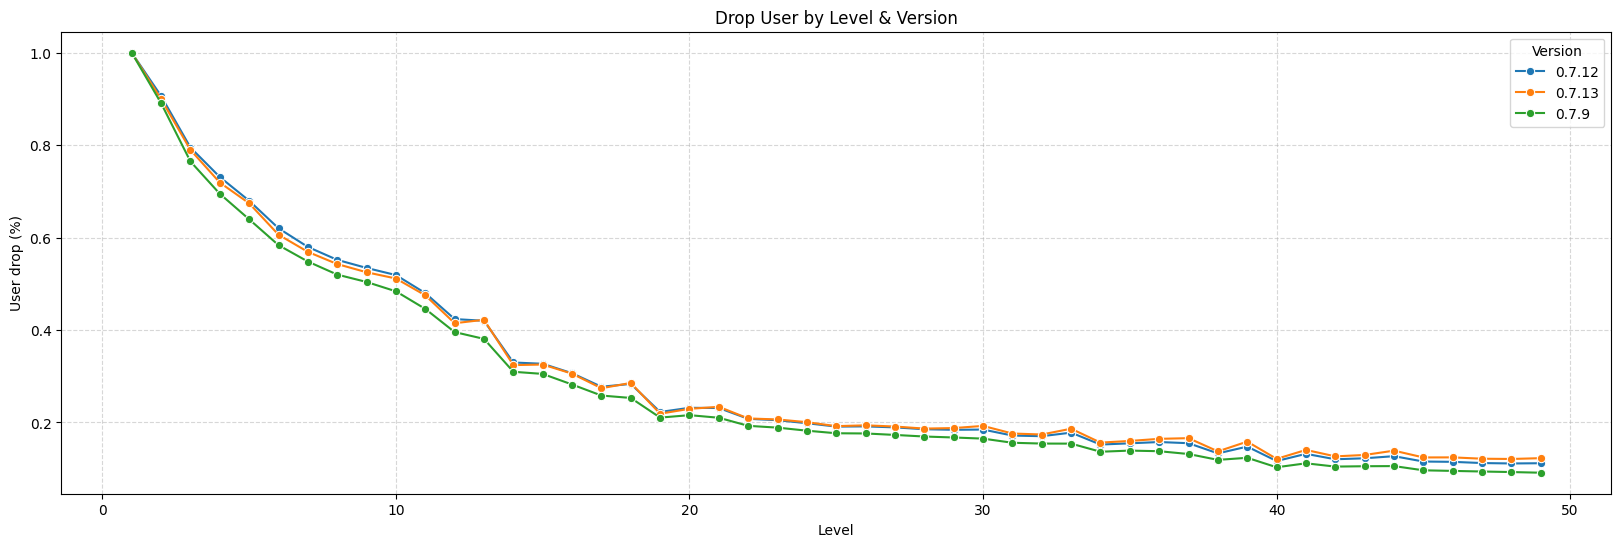

In [ ]:
# Vẽ
plt.figure(figsize=(20, 6))
sns.lineplot(data= winrate_df, x="level", y="user_drop", hue="version", marker="o")

plt.title("Drop User by Level & Version")
plt.xlabel("Level")
plt.ylabel("User drop (%)")
plt.legend(title="Version")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [ ]:
query = """
WITH user_new AS (
    SELECT version, count(distinct user_pseudo_id) as new_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28')
        )
      group by version
),
user_finish_level_30 AS (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS user_finish
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`,
    UNNEST(event_params) AS param
    WHERE event_name = 'win_level'
        AND param.key = 'level'
        AND param.value.string_value = '30'
        AND version IN ('0.7.9', '0.7.12', '0.7.13')
        AND platform = 'IOS'
        AND country = 'United States'
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND (
            (version = '0.7.9' AND date_par BETWEEN '2025-02-04' AND '2025-02-11') OR
            (version = '0.7.12' AND date_par BETWEEN '2025-02-13' AND '2025-02-20') OR
            (version = '0.7.13' AND date_par BETWEEN '2025-02-21' AND '2025-02-28'))
  AND version IN ('0.7.9', '0.7.12', '0.7.13') AND platform = 'IOS' AND country = 'United States'
  )
    GROUP BY version
)
SELECT
  un.version,
  uf.user_finish / un.new_user AS finish_rate
 FROM user_finish_level_30 uf join user_new un on uf.version = un.version ;
"""
finish_rate = client.query(query).to_dataframe()
finish_rate

,version,finish_rate
0,0.7.12,0.209226
1,0.7.9,0.198899
2,0.7.13,0.184354


<ipython-input-26-c1d5f0e34d07>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=finish_rate, x="version", y="finish_rate", palette="viridis")


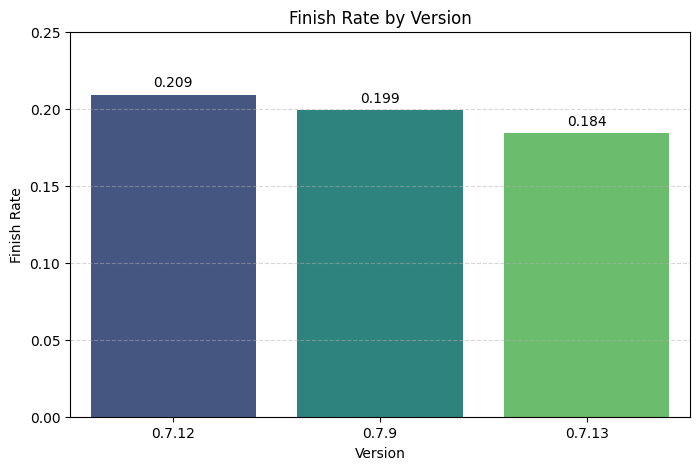

In [ ]:
# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
sns.barplot(data=finish_rate, x="version", y="finish_rate", palette="viridis")

# Thêm nhãn và tiêu đề
plt.xlabel("Version")
plt.ylabel("Finish Rate")
plt.title("Finish Rate by Version")
plt.ylim(0, 0.25)  # Điều chỉnh trục y nếu cần
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Hiển thị giá trị trên cột
for index, row in finish_rate.iterrows():
    plt.text(index, row.finish_rate + 0.005, round(row.finish_rate, 3), ha="center", fontsize=10)

plt.show()

### LTV

In [ ]:
query = """
WITH cohort AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS cohort_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'first_open' and version IN ('0.7.9') AND platform = 'IOS' AND country = 'United States'
  and date_par between '2025-02-04' and '2025-02-11'
),

sessions AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS session_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'session_start' and version IN ('0.7.9') AND platform = 'IOS' AND country = 'United States'
  and date_par between '2025-02-04' and '2025-02-11'
),

revenue AS (
SELECT
  hihi.revenue_date,
  hihi.user_id,
  IFNULL(hihi.rev_ads, 0) + IFNULL(hihi.rev_iap, 0) as revenue
FROM (
  SELECT
    date_par as revenue_date,
    user_pseudo_id as user_id,
    SUM(IFNULL(event_value_in_usd, 0)) as rev_iap,
    SUM(IFNULL((SELECT value.double_value FROM UNNEST(event_params) WHERE KEY = 'value'), 0)) AS rev_ads
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name in('in_app_purchase','ad_impression') and version IN ('0.7.9') and date_par between '2025-02-04' and '2025-02-11' AND platform = 'IOS' AND country = 'United States'
  GROUP BY 1,2
) as hihi
),

cohort_revenue AS (
  SELECT
    c.user_id,
    c.cohort_date,
    r.revenue_date,
    DATE_DIFF(r.revenue_date, c.cohort_date, DAY) AS day_number,
    IFNULL(r.revenue, 0) AS revenue
  FROM cohort c
  LEFT JOIN revenue r
    ON c.user_id = r.user_id
    AND r.revenue_date >= c.cohort_date
)

SELECT
  c.cohort_date,
  COUNT(DISTINCT c.user_id) AS total_users,
  COALESCE(SUM(CASE WHEN cr.day_number = 0 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS Day_0_ARPU,
  COALESCE(SUM(CASE WHEN cr.day_number <= 1 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_1,
  COALESCE(SUM(CASE WHEN cr.day_number <= 7 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_7
FROM cohort c
LEFT JOIN cohort_revenue cr
  ON c.user_id = cr.user_id
GROUP BY 1
ORDER BY 1;
"""

query1 = """
WITH cohort AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS cohort_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'first_open' and version IN ('0.7.12') AND platform = 'IOS' AND country = 'United States'
  and date_par between '2025-02-13' and '2025-02-20'
),

sessions AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS session_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'session_start' and version IN ('0.7.12') AND platform = 'IOS' AND country = 'United States'
  and date_par between '2025-02-13' and '2025-02-20'
),

revenue AS (
SELECT
  hihi.revenue_date,
  hihi.user_id,
  IFNULL(hihi.rev_ads, 0) + IFNULL(hihi.rev_iap, 0) as revenue
FROM (
  SELECT
    date_par as revenue_date,
    user_pseudo_id as user_id,
    SUM(IFNULL(event_value_in_usd, 0)) as rev_iap,
    SUM(IFNULL((SELECT value.double_value FROM UNNEST(event_params) WHERE KEY = 'value'), 0)) AS rev_ads
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name in('in_app_purchase','ad_impression') and version IN ('0.7.12') and date_par between '2025-02-13' and '2025-02-20' AND platform = 'IOS' AND country = 'United States'
  GROUP BY 1,2
) as hihi
),

cohort_revenue AS (
  SELECT
    c.user_id,
    c.cohort_date,
    r.revenue_date,
    DATE_DIFF(r.revenue_date, c.cohort_date, DAY) AS day_number,
    IFNULL(r.revenue, 0) AS revenue
  FROM cohort c
  LEFT JOIN revenue r
    ON c.user_id = r.user_id
    AND r.revenue_date >= c.cohort_date
)

SELECT
  c.cohort_date,
  COUNT(DISTINCT c.user_id) AS total_users,
  COALESCE(SUM(CASE WHEN cr.day_number = 0 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS Day_0_ARPU,
  COALESCE(SUM(CASE WHEN cr.day_number <= 1 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_1,
  COALESCE(SUM(CASE WHEN cr.day_number <= 7 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_7,
  COALESCE(SUM(cr.revenue), 0) / COUNT(DISTINCT c.user_id) AS LTV_Total
FROM cohort c
LEFT JOIN cohort_revenue cr
  ON c.user_id = cr.user_id
GROUP BY 1
ORDER BY 1;
"""

query2= """
WITH cohort AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS cohort_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'first_open' and version IN ('0.7.13') AND platform = 'IOS' AND country = 'United States'
  and date_par >= '2025-02-21'
),

sessions AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS session_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'session_start' and version IN ('0.7.13') AND platform = 'IOS' AND country = 'United States'
  and date_par >= '2025-02-21'
),

revenue AS (
SELECT
  hihi.revenue_date,
  hihi.user_id,
  IFNULL(hihi.rev_ads, 0) + IFNULL(hihi.rev_iap, 0) as revenue
FROM (
  SELECT
    date_par as revenue_date,
    user_pseudo_id as user_id,
    SUM(IFNULL(event_value_in_usd, 0)) as rev_iap,
    SUM(IFNULL((SELECT value.double_value FROM UNNEST(event_params) WHERE KEY = 'value'), 0)) AS rev_ads
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name in('in_app_purchase','ad_impression') and version IN ('0.7.13') and date_par >= '2025-02-21' AND platform = 'IOS' AND country = 'United States'
  GROUP BY 1,2
) as hihi
),

cohort_revenue AS (
  SELECT
    c.user_id,
    c.cohort_date,
    r.revenue_date,
    DATE_DIFF(r.revenue_date, c.cohort_date, DAY) AS day_number,
    IFNULL(r.revenue, 0) AS revenue
  FROM cohort c
  LEFT JOIN revenue r
    ON c.user_id = r.user_id
    AND r.revenue_date >= c.cohort_date
)

SELECT
  c.cohort_date,
  COUNT(DISTINCT c.user_id) AS total_users,
  COALESCE(SUM(CASE WHEN cr.day_number = 0 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS Day_0_ARPU,
  COALESCE(SUM(CASE WHEN cr.day_number <= 1 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_1,
  COALESCE(SUM(CASE WHEN cr.day_number <= 7 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_7,
  COALESCE(SUM(cr.revenue), 0) / COUNT(DISTINCT c.user_id) AS LTV_Total
FROM cohort c
LEFT JOIN cohort_revenue cr
  ON c.user_id = cr.user_id
GROUP BY 1
ORDER BY 1;
"""

# To data frame
ltv_0_7_12 = client.query(query1).to_dataframe()
ltv_0_7_13 = client.query(query2).to_dataframe()
ltv_0_7_9 = client.query(query).to_dataframe()
# Style the DataFrame
ltv_0_7_12 = ltv_0_7_12.style.background_gradient(cmap='Greens', axis=0)
ltv_0_7_13 = ltv_0_7_13.style.background_gradient(cmap='Greens', axis=0)
ltv_0_7_9 = ltv_0_7_9.style.background_gradient(cmap='Greens', axis=0)


In [ ]:
import pandas as pd
from IPython.display import HTML, display
html_str = f"""
<div style="display: flex; justify-content: space-around;">
    <div style="margin: 10px;">
        <h3>ltv_0_7_12</h3>
        {ltv_0_7_12.to_html()}
    </div>
    <div style="margin: 10px;">
        <h3>ltv_0_7_13</h3>
        {ltv_0_7_13.to_html()}
    </div>
    <div style="margin: 10px;">
        <h3>ltv_0_7_9</h3>
        {ltv_0_7_9.to_html()}
    </div>
</div>
"""

# Display the HTML structure
display(HTML(html_str))

,cohort_date,total_users,Day_0_ARPU,LTV_Day_1,LTV_Day_7,LTV_Total
0,2025-02-13,2960,0.199381,0.264998,0.366502,0.366502
1,2025-02-14,3395,0.159159,0.214830,0.292401,0.292401
2,2025-02-15,3969,0.127436,0.208036,0.305306,0.305306
3,2025-02-16,5124,0.139137,0.201485,0.250911,0.250911
4,2025-02-17,5674,0.131792,0.176478,0.230171,0.230171
5,2025-02-18,6118,0.152633,0.207855,0.235501,0.235501
6,2025-02-19,4269,0.144503,0.207678,0.207678,0.207678
7,2025-02-20,3783,0.123776,0.123776,0.123776,0.123776
,cohort_date,total_users,Day_0_ARPU,LTV_Day_1,LTV_Day_7,LTV_Total
0,2025-02-21,2256,0.234918,0.352311,0.476110,0.476110


### Kết luận

Kết hợp các chỉ số:
- Retention: Không quá rõ ràng
- Engagement Time: 0.7.9 > 0.7.12 > 0.7.13
- AVG Time Per session: ngang nhau
- avg time per user & avg session per user: 0.7.9 > 0.7.12 > 0.7.13
- ARPU: Có thể coi là ngang nhau
- Pay_rate: 0.7.13 > 0.7.12 > 0.7.9
- Ads Shown rate: 0.7.9 ~ 0.7.12 > 0.7.13
- Ads reward complete rate/ Ads reward click: 0.7.12 > 2 version còn lại
- Rev_from_ad/iap_per_user: ngang nhau
- Level churn: 0.7.13 > 0.7.12 > 0.7.9
- LTV: 0.7.13 > 0.7.12 > 0.7.9

Kết luận : 0.7.13

## Android

### Xu hướng user mới

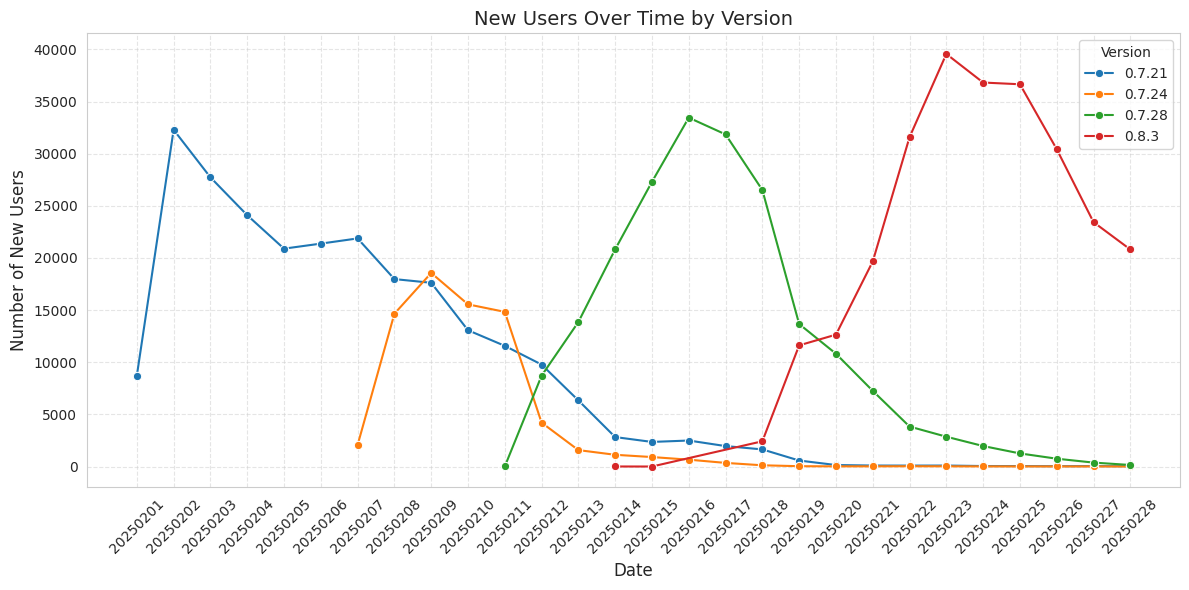

In [ ]:
# Query to get new users by date
new_users_query = """
SELECT
    event_date,
    version,
    COUNT(DISTINCT CASE WHEN event_name = 'first_open' THEN user_pseudo_id END) as new_users
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE platform = 'ANDROID'
	AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
GROUP BY event_date, version
ORDER BY event_date;
"""

new_users = client.query(new_users_query).to_dataframe()
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Giả sử dữ liệu của bạn được lưu trong DataFrame có tên 'new_user_data'
# Vẽ biểu đồ line
plt.figure(figsize=(12, 6))
sns.lineplot(data=new_users, x='event_date', y='new_users', hue='version', marker='o')

# Thiết lập tiêu đề và nhãn
plt.title('New Users Over Time by Version', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of New Users', fontsize=12)
plt.xticks(rotation=45)  # Xoay nhãn ngày cho dễ đọc
plt.legend(title='Version')

# Hiển thị lưới
plt.grid(True, linestyle="--", alpha=0.5)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [ ]:
query1 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-05' and '2025-02-12'
    and version = '0.7.9' and country = 'United States' and platform = 'IOS'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-05' and '2025-02-12' and version = '0.7.9' and country = 'United States' and platform = 'IOS') e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""

query2 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-13' and '2025-02-20'
    and version = '0.7.12' and country = 'United States' and platform = 'IOS'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-13' and '2025-02-20'  and version = '0.7.12' and country = 'United States' and platform = 'IOS' ) e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""


query3 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-21' and '2025-02-28'
    and version = '0.7.13' and country = 'United States' and platform = 'IOS'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-21' and '2025-02-28'  and version = '0.7.13' and country = 'United States' and platform = 'IOS' ) e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""
retention_0_7_9 = client.query(query1).to_dataframe()
retention_0_7_12 = client.query(query2).to_dataframe()
retention_0_7_13 = client.query(query3).to_dataframe()

#pivot
retention_0_7_9_pivot = retention_0_7_9.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)
retention_0_7_12_pivot = retention_0_7_12.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)
retention_0_7_13_pivot = retention_0_7_13.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)


import matplotlib.pyplot as plt
import seaborn as sns

# Tạo figure với 3 subplot (1 hàng, 3 cột)
fig, axes = plt.subplots(1, 3, figsize=(30, 12))

# Heatmap cho phiên bản 1.29.5
sns.heatmap(data=retention_0_7_9_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[0])
axes[0].set_title("Retention Rate 0.7.9", fontsize=16)
axes[0].set_xlabel('Days since first open')
axes[0].set_ylabel('Date')

# Heatmap cho phiên bản 1.30
sns.heatmap(data=retention_0_7_12_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[1])
axes[1].set_title("Retention Rate 0.7.12 ", fontsize=16)
axes[1].set_xlabel('Days since first open')
axes[1].set_ylabel('')

# Heatmap cho phiên bản 1.35.2
sns.heatmap(data=retention_0_7_13_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[2])
axes[2].set_title("Retention Rate 0.7.13", fontsize=16)
axes[2].set_xlabel('Days since first open')
axes[2].set_ylabel('')

# Căn chỉnh layout để các heatmap không bị chồng lên nhau
plt.tight_layout()
plt.show()


### Cohort giữa 4 app

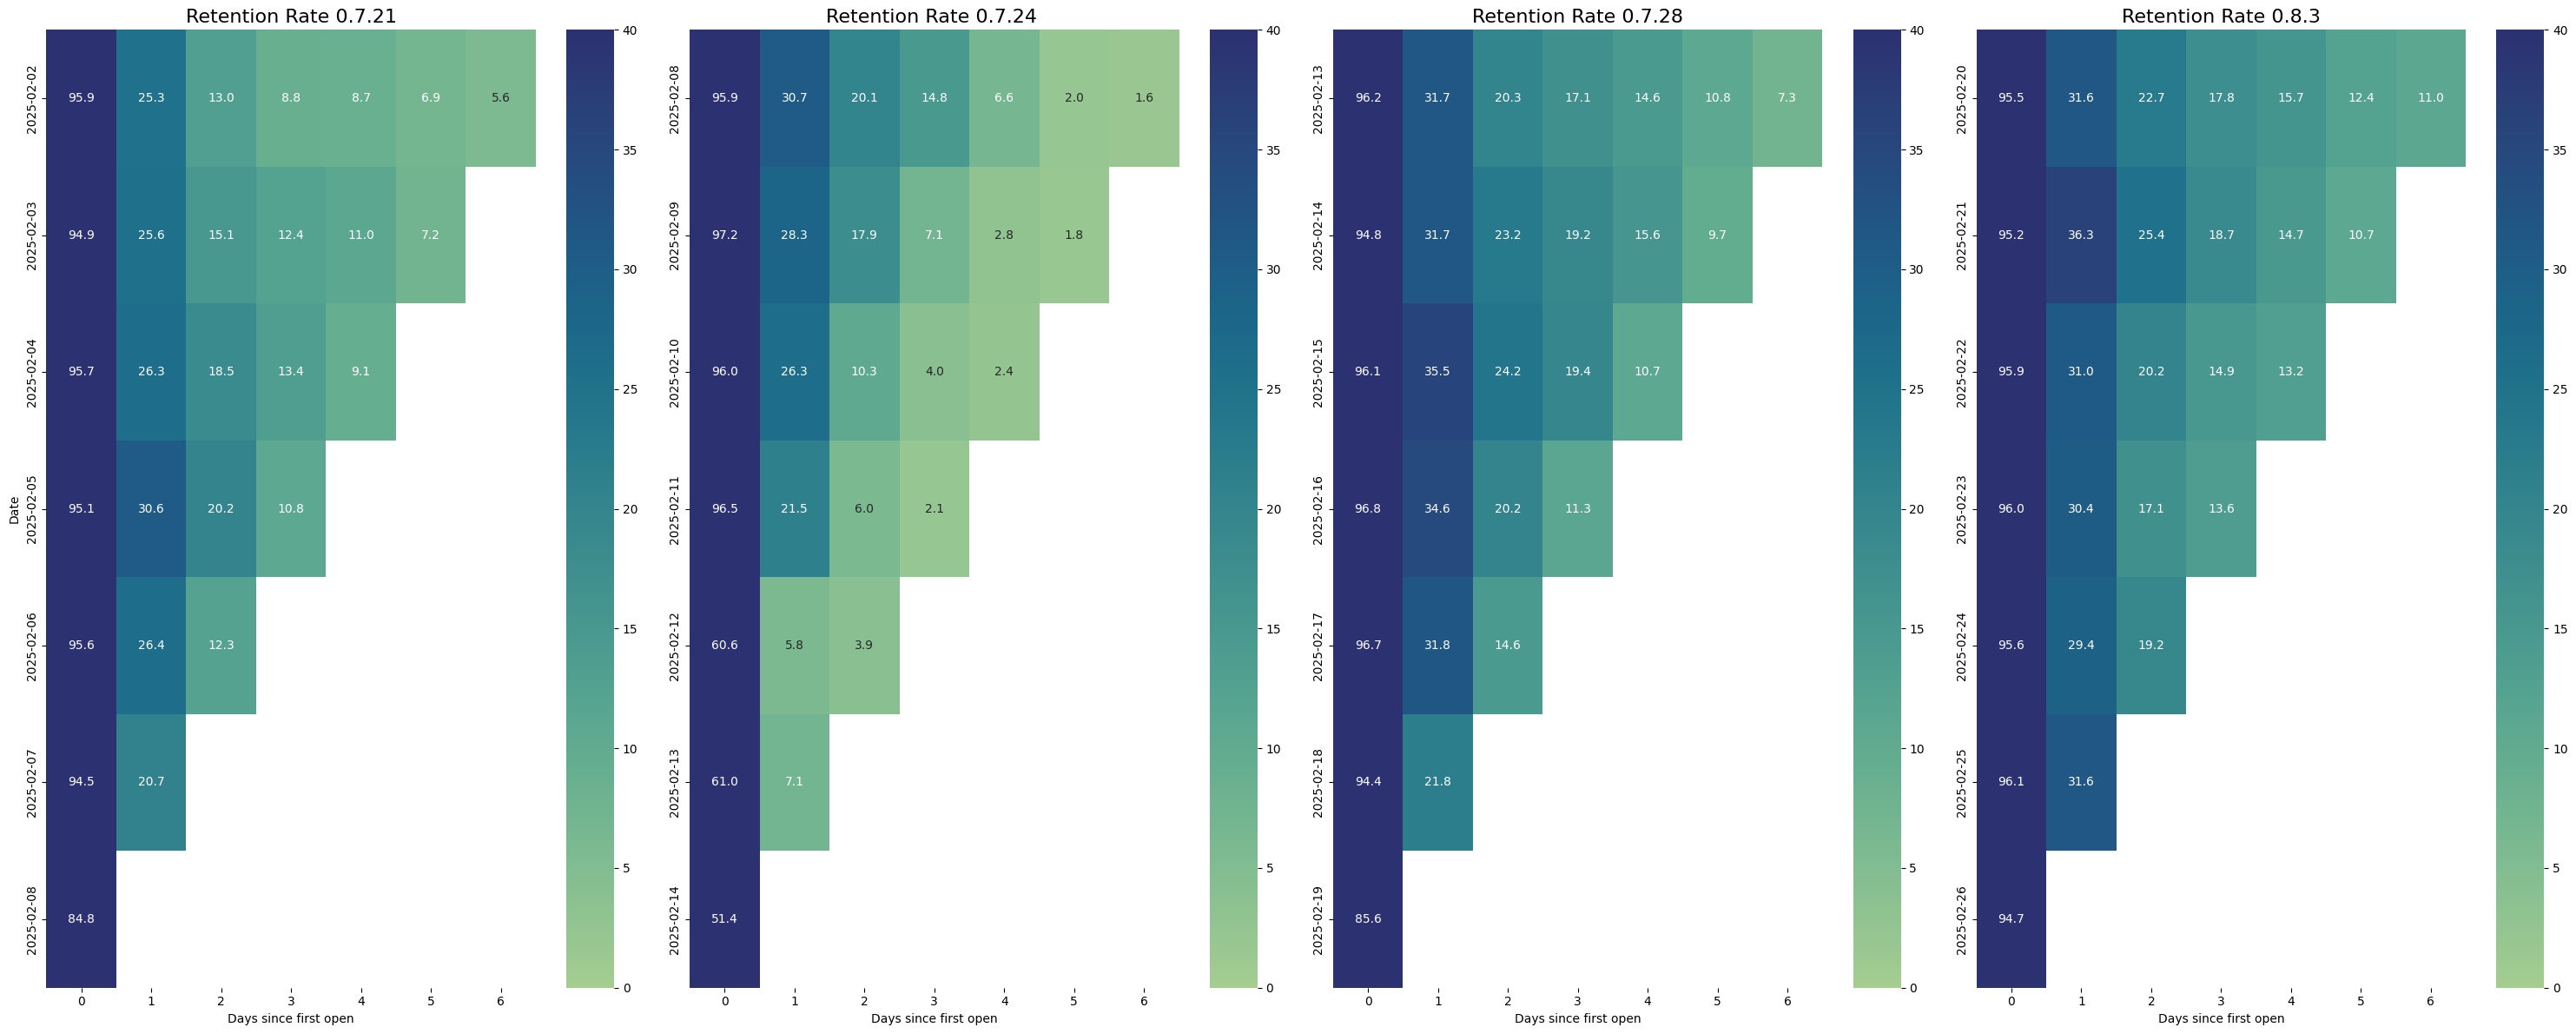

In [10]:
query1 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-02' and '2025-02-08'
    and version = '0.7.21' and country = 'United States' and platform = 'ANDROID'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-02' and '2025-02-08' and version = '0.7.21' and country = 'United States' and platform = 'ANDROID') e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""

query2 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-08' and '2025-02-14'
    and version = '0.7.24' and country = 'United States' and platform = 'ANDROID'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-08' and '2025-02-14'  and version = '0.7.24' and country = 'United States' and platform = 'ANDROID' ) e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""


query3 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-13' and '2025-02-19'
    and version = '0.7.28' and country = 'United States' and platform = 'ANDROID'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-13' and '2025-02-19'  and version = '0.7.28' and country = 'United States' and platform = 'ANDROID' ) e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""

query4 = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
    and PARSE_DATE('%Y%m%d', event_date) between '2025-02-20' and '2025-02-26'
    and version = '0.8.3' and country = 'United States' and platform = 'ANDROID'
),
cohort_sizes AS (
    SELECT
        cohort_date,
        COUNT(DISTINCT user_pseudo_id) as total_users
    FROM cohort
    GROUP BY cohort_date
),
daily_retention AS (
    SELECT
        c.cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), c.cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'user_engagement') THEN e.user_pseudo_id END) as retained_users,
        cs.total_users
    FROM cohort c
    LEFT JOIN (select * from `royal-hexa-in-house.pixon_data_science.003_mock` where PARSE_DATE('%Y%m%d', event_date) between '2025-02-20' and '2025-02-26'  and version = '0.8.3' and country = 'United States' and platform = 'ANDROID' ) e
        ON c.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) >= c.cohort_date
    JOIN cohort_sizes cs
        ON c.cohort_date = cs.cohort_date
    GROUP BY c.cohort_date, days_since_first_open, cs.total_users
)
SELECT
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
-- WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""




retention_0_7_21 = client.query(query1).to_dataframe()
retention_0_7_24 = client.query(query2).to_dataframe()
retention_0_7_28 = client.query(query3).to_dataframe()
retention_0_8_3 = client.query(query4).to_dataframe()

#pivot
retention_0_7_21_pivot = retention_0_7_21.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)
retention_0_7_24_pivot = retention_0_7_24.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)
retention_0_7_28_pivot = retention_0_7_28.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)
retention_0_8_3_pivot = retention_0_8_3.pivot(
    index='cohort_date',
    columns='days_since_first_open',
    values='retention_rate'
)


import matplotlib.pyplot as plt
import seaborn as sns

# Tạo figure với 3 subplot (1 hàng, 4 cột)
fig, axes = plt.subplots(1, 4, figsize=(30, 12))

# Heatmap cho phiên bản 1.29.5
sns.heatmap(data=retention_0_7_21_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[0])
axes[0].set_title("Retention Rate 0.7.21", fontsize=16)
axes[0].set_xlabel('Days since first open')
axes[0].set_ylabel('Date')

# Heatmap cho phiên bản 1.30
sns.heatmap(data=retention_0_7_24_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[1])
axes[1].set_title("Retention Rate 0.7.24 ", fontsize=16)
axes[1].set_xlabel('Days since first open')
axes[1].set_ylabel('')

# Heatmap cho phiên bản 1.35.2
sns.heatmap(data=retention_0_7_28_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[2])
axes[2].set_title("Retention Rate 0.7.28", fontsize=16)
axes[2].set_xlabel('Days since first open')
axes[2].set_ylabel('')

# Heatmap cho phiên bản 1.35.2
sns.heatmap(data=retention_0_8_3_pivot, annot=True, vmin=0, vmax=40, cmap='crest', fmt=".1f", ax=axes[3])
axes[3].set_title("Retention Rate 0.8.3", fontsize=16)
axes[3].set_xlabel('Days since first open')
axes[3].set_ylabel('')

# Căn chỉnh layout để các heatmap không bị chồng lên nhau
plt.tight_layout()
plt.show()


### Chỉ số playtime

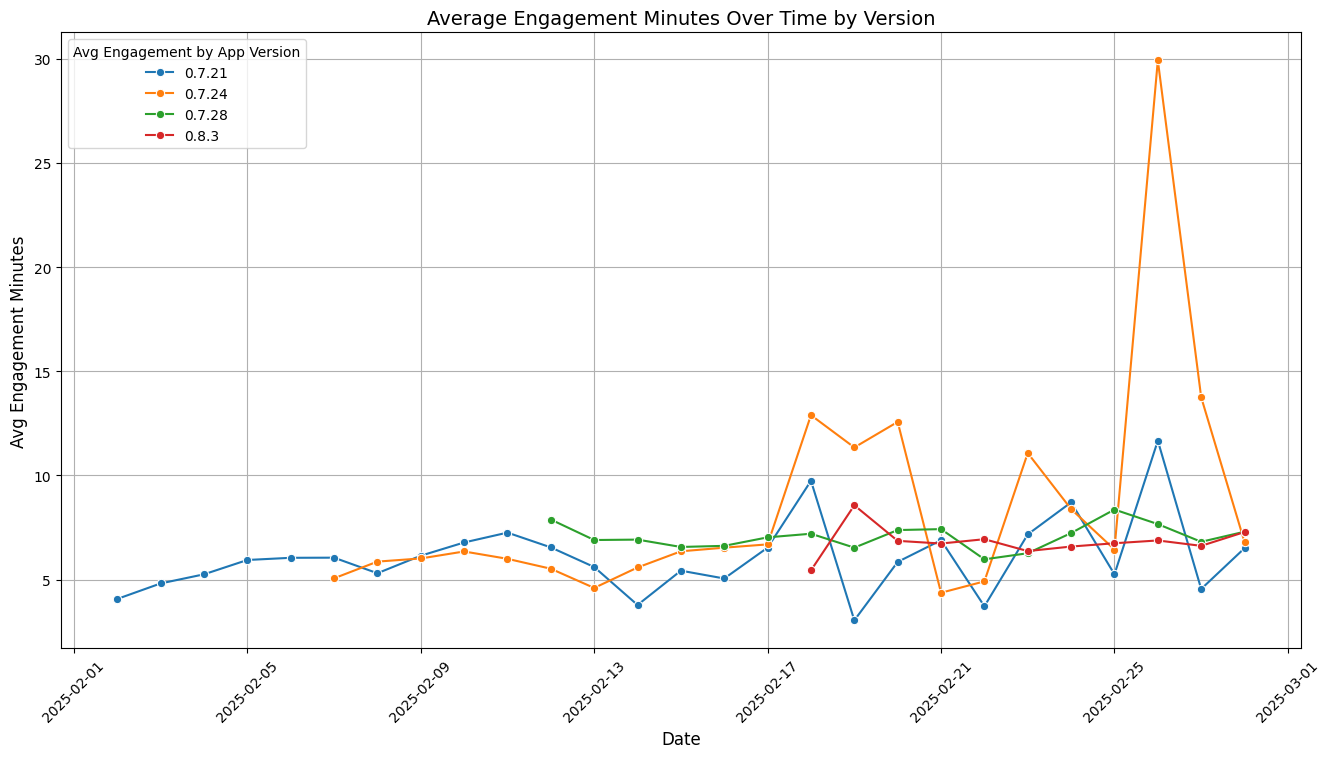

In [ ]:
query ="""
SELECT date_par,
       version,
       sum((SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'engagement_time_msec'))
       / count(distinct user_pseudo_id) --user active
       / 60000 AS avg_engage_minutes,
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'user_engagement'
AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') and country = 'United States' and platform = 'ANDROID'
AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26')
  )  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND country = 'United States' AND platform = 'ANDROID'
  )
GROUP BY date_par, version
ORDER BY date_par;
"""
playtime = client.query(query).to_dataframe()
# Vẽ biểu đồ line chart với Seaborn
plt.figure(figsize=(16, 8))
sns.lineplot(data=playtime, x='date_par', y='avg_engage_minutes', hue='version', marker='o')

# Tùy chỉnh biểu đồ
plt.title("Average Engagement Minutes Over Time by Version", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Avg Engagement Minutes", fontsize=12)
plt.xticks(rotation=45)  # Xoay nhãn ngày cho dễ đọc
plt.legend(title="Avg Engagement by App Version")
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

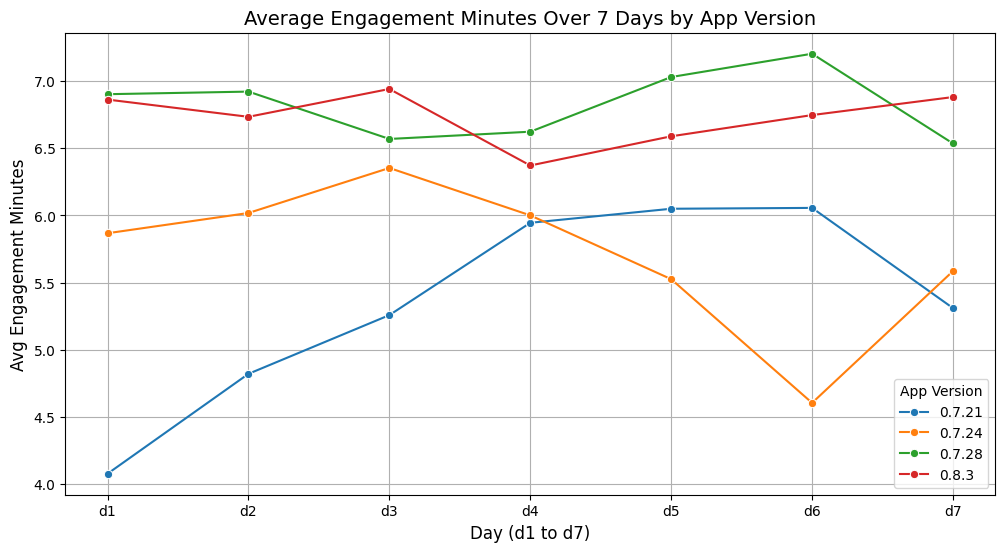

In [ ]:
query = """
WITH filtered_data AS (
    SELECT date_par,
           version,
           SUM((SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'engagement_time_msec'))
           / COUNT(DISTINCT user_pseudo_id) / 60000 AS avg_engage_minutes,
           CASE
               WHEN version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-02', DAY) + 1 AS STRING))
               WHEN version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-08', DAY) + 1 AS STRING))
               WHEN version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
               WHEN version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-20', DAY) + 1 AS STRING))
           END AS day_label
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
      AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') and platform = 'ANDROID'
      AND country = 'United States' and platform = 'ANDROID'
      AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY date_par, version
)
SELECT day_label, version, AVG(avg_engage_minutes) AS avg_engage_minutes
FROM filtered_data
WHERE day_label IS NOT NULL
GROUP BY day_label, version
ORDER BY version, day_label;
"""

# Lấy dữ liệu từ BigQuery
playtime = client.query(query).to_dataframe()

# Vẽ biểu đồ line chart với Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=playtime, x='day_label', y='avg_engage_minutes', hue='version', marker='o')

# Tùy chỉnh biểu đồ
plt.title("Average Engagement Minutes Over 7 Days by App Version", fontsize=14)
plt.xlabel("Day (d1 to d7)", fontsize=12)
plt.ylabel("Avg Engagement Minutes", fontsize=12)
plt.xticks(rotation=0)  # Xoay nhãn ngày cho dễ đọc
plt.legend(title="App Version")
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


### Các chỉ số liên quan playtime

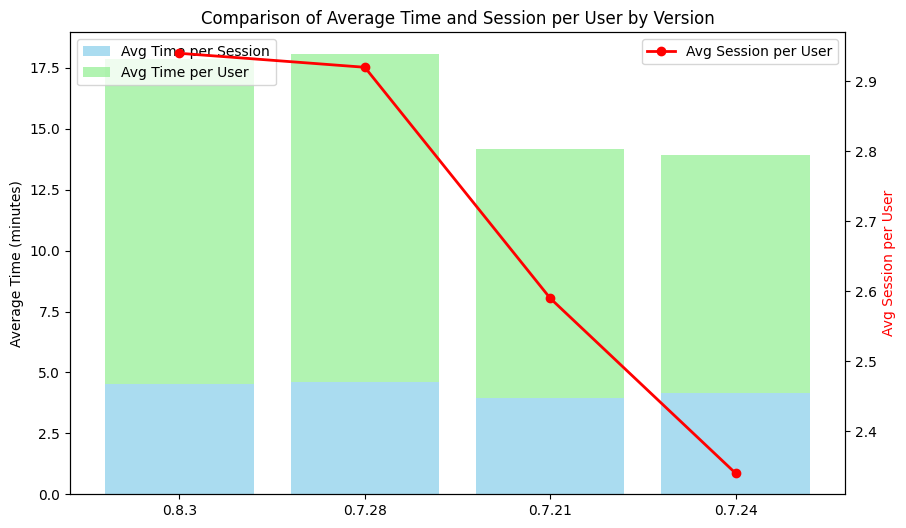

In [8]:
query = """
SELECT
  version,
   COUNT(DISTINCT CASE WHEN ep.key = 'ga_session_id' THEN ep.value.int_value END) AS total_session,
  SUM(CASE WHEN ep.key = 'engagement_time_msec' THEN ep.value.int_value END) AS total_engagement_time,
  COUNT(DISTINCT user_pseudo_id) AS total_users,
  ROUND((SUM(CASE WHEN ep.key = 'engagement_time_msec' THEN ep.value.int_value END) / COUNT(DISTINCT CASE WHEN ep.key = 'ga_session_id' THEN ep.value.int_value END)/60000), 2) AS avg_time_per_session,
  ROUND((SUM(CASE WHEN ep.key = 'engagement_time_msec' THEN ep.value.int_value END) / COUNT(DISTINCT user_pseudo_id)/60000), 2) AS avg_time_per_user,
  ROUND(COUNT(DISTINCT CASE WHEN ep.key = 'ga_session_id' THEN ep.value.int_value END) / COUNT(DISTINCT user_pseudo_id), 2) AS avg_session_per_user
FROM `royal-hexa-in-house.pixon_data_science.003_mock`,
UNNEST(event_params) AS ep
WHERE event_name = 'user_engagement'
  AND platform = 'ANDROID' AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND country = 'United States'
  AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
GROUP BY version
ORDER BY total_users DESC
"""

playtime = client.query(query).to_dataframe()

import pandas as pd
import matplotlib.pyplot as plt


# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(10, 6))

# Vẽ stacked column chart
ax1.bar(playtime['version'], playtime['avg_time_per_session'], label='Avg Time per Session', color='skyblue', alpha=0.7)
ax1.bar(playtime['version'], playtime['avg_time_per_user'], bottom=playtime['avg_time_per_session'], label='Avg Time per User', color='lightgreen', alpha=0.7)

# Thiết lập trục y cho cột
ax1.set_ylabel('Average Time (minutes)', color='black')
ax1.set_title('Comparison of Average Time and Session per User by Version')
ax1.legend(loc='upper left')

# Tạo trục y thứ hai cho line chart
ax2 = ax1.twinx()
ax2.plot(playtime['version'], playtime['avg_session_per_user'], color='red', marker='o', label='Avg Session per User', linewidth=2)
ax2.set_ylabel('Avg Session per User', color='red')
ax2.legend(loc='upper right')

# Hiển thị biểu đồ
plt.show()


### ARPU

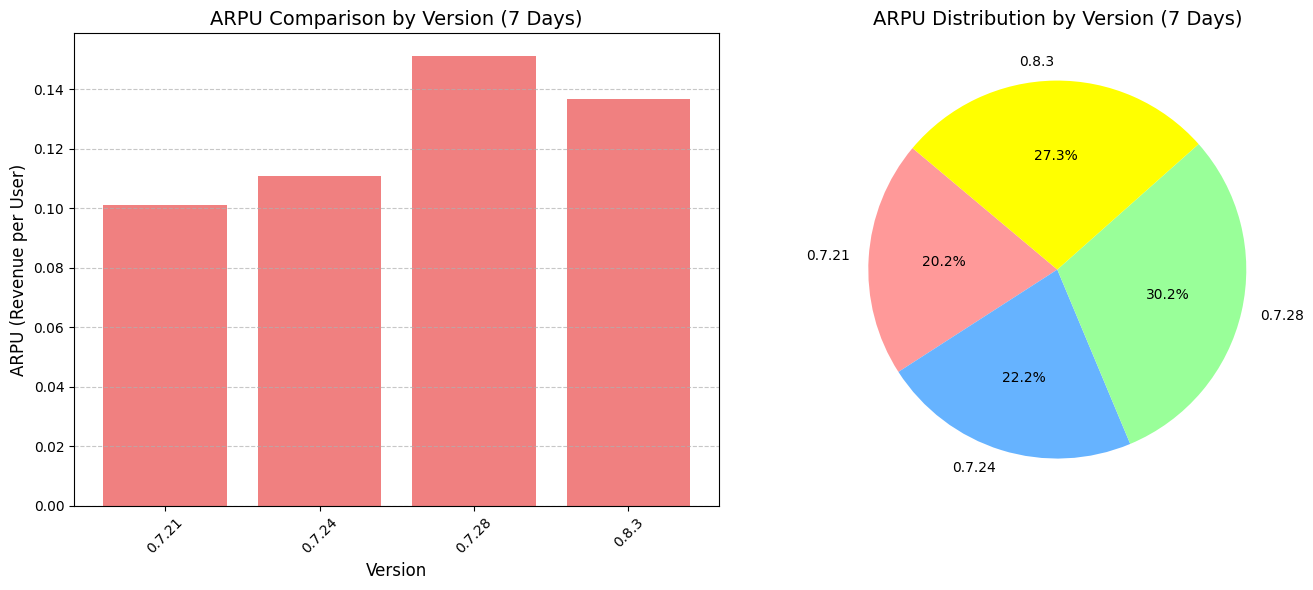

In [16]:
query = """
WITH user_data AS (
    SELECT version,
           CASE
               WHEN version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08' THEN '0.7.21'
               WHEN version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14' THEN '0.7.24'
               WHEN version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19' THEN '0.7.28'
               WHEN version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26' THEN '0.8.3'
           END AS version_group,
           COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
      AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
      AND country = 'United States'  and platform = 'ANDROID'
      AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version, version_group
),
iap AS (
    SELECT version,
           CASE
               WHEN version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08' THEN '0.7.21'
               WHEN version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14' THEN '0.7.24'
               WHEN version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19' THEN '0.7.28'
               WHEN version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26' THEN '0.8.3'
           END AS version_group,
           SUM(event_value_in_usd) AS revenue_from_iap
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
      AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
      AND country = 'United States'  and platform = 'ANDROID'
      AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version, version_group
),
ads AS (
    SELECT version,
           CASE
               WHEN version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08' THEN '0.7.21'
               WHEN version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14' THEN '0.7.24'
               WHEN version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19' THEN '0.7.28'
               WHEN version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26' THEN '0.8.3'
           END AS version_group,
           SUM((SELECT value.double_value FROM UNNEST(event_params) WHERE key = 'value')) AS revenue_from_ad
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ad_impression'
      AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')  and platform = 'ANDROID'
      AND country = 'United States'
      AND user_pseudo_id in
 (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version, version_group
)
SELECT user_data.version_group AS version,
       revenue_from_iap + revenue_from_ad AS total_revenue,
       num_user,
       (revenue_from_iap + revenue_from_ad) / num_user AS ARPU
FROM user_data
JOIN iap ON user_data.version_group = iap.version_group
JOIN ads ON user_data.version_group = ads.version_group
ORDER BY version;
"""

# Lấy dữ liệu từ BigQuery
arpu_data = client.query(query).to_dataframe()

# Tạo figure với 2 subplot (1 hàng, 2 cột)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Vẽ biểu đồ cột so sánh ARPU
axes[0].bar(arpu_data['version'], arpu_data['ARPU'], color='lightcoral')
axes[0].set_title('ARPU Comparison by Version (7 Days)', fontsize=14)
axes[0].set_xlabel('Version', fontsize=12)
axes[0].set_ylabel('ARPU (Revenue per User)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Vẽ biểu đồ pie thể hiện tỷ lệ ARPU của từng phiên bản
axes[1].pie(arpu_data['ARPU'], labels=arpu_data['version'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#FFFF00'])
axes[1].set_title('ARPU Distribution by Version (7 Days)', fontsize=14)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

### Rev from iap,ads

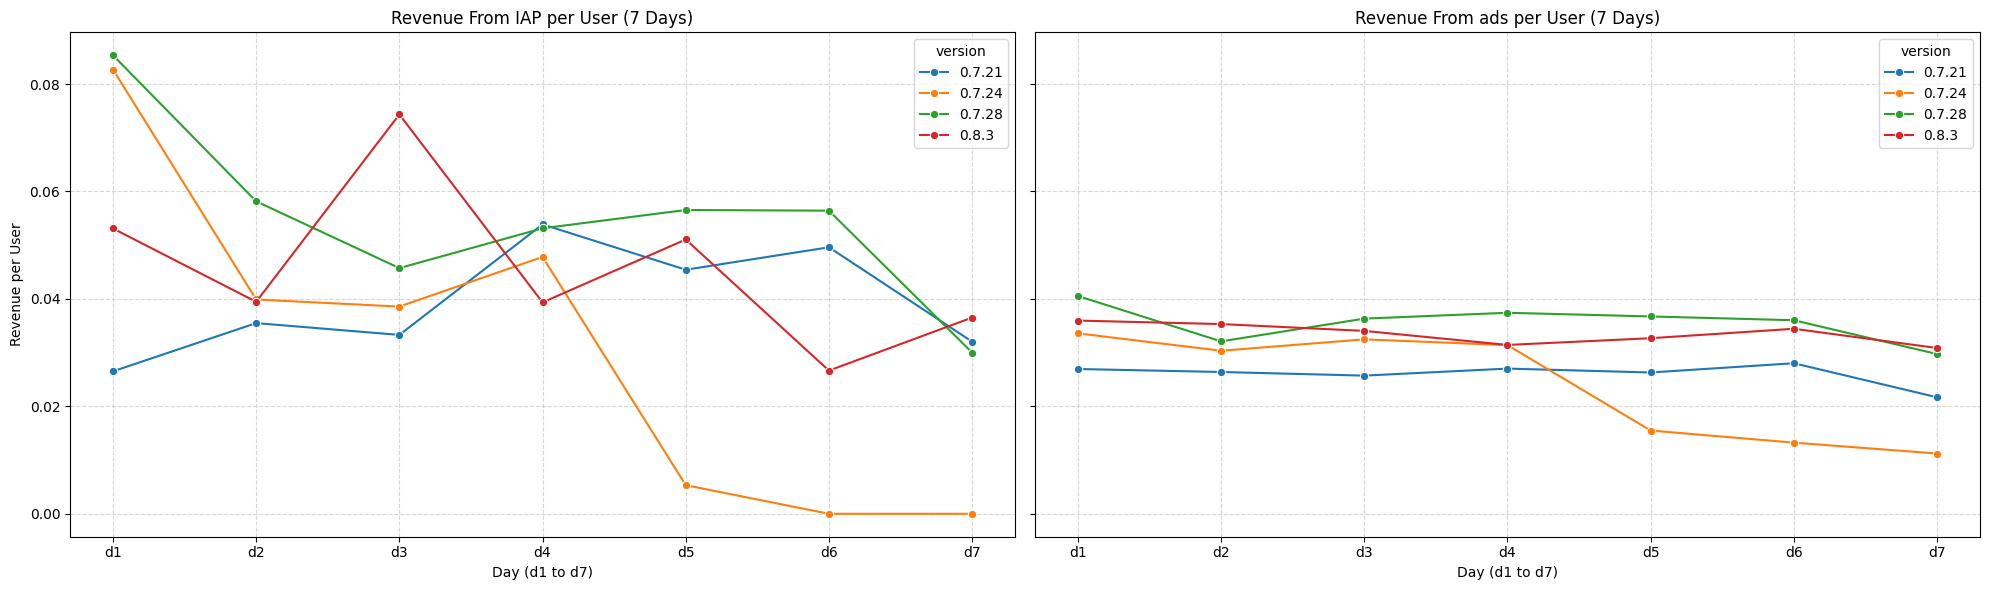

In [ ]:
QUERY1 = """
WITH ads AS (
    SELECT
        version,
        CASE
               WHEN version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-02', DAY) + 1 AS STRING))
               WHEN version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-08', DAY) + 1 AS STRING))
               WHEN version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
               WHEN version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-20', DAY) + 1 AS STRING))
           END AS day_label,
        sum(event_value_in_usd) as revenue_from_iap_InUSD
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND user_pseudo_id in
 (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version, day_label
),
user AS (
    SELECT
        version,
        CASE
               WHEN version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-02', DAY) + 1 AS STRING))
               WHEN version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-08', DAY) + 1 AS STRING))
               WHEN version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
               WHEN version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-20', DAY) + 1 AS STRING))
           END AS day_label,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND user_pseudo_id in
 (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version, day_label
)
SELECT
    user.version,
    user.day_label,
    COALESCE(revenue_from_iap_InUSD, 0) / NULLIF(num_user, 0) AS rev_iap_per_user
FROM user
LEFT JOIN ads ON user.version = ads.version AND user.day_label = ads.day_label
WHERE user.day_label IS NOT NULL
ORDER BY version, day_label;
"""
rev_from_iap_by_days = client.query(QUERY1).to_dataframe()

QUERY2 = """
WITH ads AS (
    SELECT
        version,
        CASE
               WHEN version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-02', DAY) + 1 AS STRING))
               WHEN version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-08', DAY) + 1 AS STRING))
               WHEN version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
               WHEN version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-20', DAY) + 1 AS STRING))
           END AS day_label,
        SUM((SELECT value.double_value FROM UNNEST(event_params) WHERE key = 'value')) AS revenue_from_ad
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ad_impression'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND user_pseudo_id in
 (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version, day_label
),
user AS (
    SELECT
        version,
        CASE
               WHEN version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-02', DAY) + 1 AS STRING))
               WHEN version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-08', DAY) + 1 AS STRING))
               WHEN version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-13', DAY) + 1 AS STRING))
               WHEN version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26' THEN CONCAT('d', CAST(DATE_DIFF(date_par, '2025-02-20', DAY) + 1 AS STRING))
           END AS day_label,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND user_pseudo_id in
 (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version, day_label
)
SELECT
    user.version,
    user.day_label,
    COALESCE(revenue_from_ad, 0) / NULLIF(num_user, 0) AS rev_ad_per_user
FROM user
LEFT JOIN ads ON user.version = ads.version AND user.day_label = ads.day_label
WHERE user.day_label IS NOT NULL
ORDER BY version, day_label;
"""
rev_from_ads_by_days = client.query(QUERY2).to_dataframe()

# Vẽ biểu đồ line
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot 1: Revenue from Ads per User
sns.lineplot(ax=axes[0], data=rev_from_iap_by_days, x="day_label", y="rev_iap_per_user", hue="version", marker="o")
axes[0].set_title("Revenue From IAP per User (7 Days)")
axes[0].set_xlabel("Day (d1 to d7)")
axes[0].set_ylabel("Revenue per User")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot 2: Revenue from IAP per User
sns.lineplot(ax=axes[1], data=rev_from_ads_by_days, x="day_label", y="rev_ad_per_user", hue="version", marker="o")
axes[1].set_title("Revenue From ads per User (7 Days)")
axes[1].set_xlabel("Day (d1 to d7)")
axes[1].grid(True, linestyle="--", alpha=0.5)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

### Kết hợp các chỉ số

In [14]:
query = """
WITH iap AS (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS user_iap
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
        AND user_pseudo_id in
(
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version
),
user AS (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
        AND user_pseudo_id in
(
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version
),
ad_rw as (
  SELECT
  version,
  COUNT( user_pseudo_id) AS num_ads_rw
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ads_reward_complete'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
        AND user_pseudo_id in
(
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    group by version
),
ad_rw_click as (
  SELECT
  version,
  COUNT( user_pseudo_id) AS num_ads_rw_click
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ads_reward_click'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    group by version
),
ads_shown as(
  SELECT
  version,
  COUNT( user_pseudo_id) AS ads_shown
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ad_impression'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
        AND user_pseudo_id in
  (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    group by version
)
SELECT
    user.version,
    COALESCE(user_iap, 0) / NULLIF(num_user, 0) AS pay_rate,
    COALESCE(num_ads_rw, 0) / NULLIF(num_user, 0) AS ad_rw_complete_rate,
    COALESCE(num_ads_rw_click, 0) / NULLIF(num_user, 0) AS ads_rw_click_rate,
    COALESCE(ads_shown.ads_shown, 0) / NULLIF(num_user, 0) AS ad_impression_rate
FROM user
LEFT JOIN iap ON user.version = iap.version
join ad_rw on user.version = ad_rw.version
join ads_shown on user.version = ads_shown.version
join ad_rw_click on user.version = ad_rw_click.version
ORDER BY version;
"""

# Lấy dữ liệu từ BigQuery
pay_rate = client.query(query).to_dataframe()
pay_rate

,version,pay_rate,ad_rw_complete_rate,ads_rw_click_rate,ad_impression_rate
0,0.7.21,0.007247,3.111761,1.250050,244.159697
1,0.7.24,0.008456,4.297741,1.538180,296.352013
2,0.7.28,0.011867,6.206325,2.124217,394.860723
3,0.8.3,0.010376,5.922292,2.041335,390.742119


In [23]:
 query = """
 With rev_ad as(
  SELECT
  version,
   SUM((SELECT value.double_value FROM UNNEST(event_params) WHERE key = 'value')) AS revenue_from_ad
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'ad_impression'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States' AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
        AND user_pseudo_id in
 (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version
 ), rev_iap as (
  SELECT
        version,
        sum(event_value_in_usd) as revenue_from_iap_InUSD
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'in_app_purchase'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States' AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
        AND user_pseudo_id in
 (
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  )
    GROUP BY version
 ),
 user as (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS num_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'user_engagement'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
        AND user_pseudo_id in
(
SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States')
    GROUP BY version
 )
 select
  user.version,
  rev_ad.revenue_from_ad,
  rev_iap.revenue_from_iap_InUSD,
  rev_ad.revenue_from_ad/user.num_user as rev_from_ad_per_user,
  rev_iap.revenue_from_iap_InUSD/user.num_user as rev_from_iap_per_user,
  user.num_user
 from user
 join rev_ad on user.version = rev_ad.version
 join rev_iap on user.version = rev_iap.version
 """
 rev= client.query(query).to_dataframe()
 rev

,version,revenue_from_ad,revenue_from_iap_InUSD,rev_from_ad_per_user,rev_from_iap_per_user,num_user
0,0.7.28,999.736270,1509.70,0.060225,0.090946,16600
1,0.7.21,603.984724,915.79,0.040156,0.060886,15041
2,0.8.3,1029.174936,1393.06,0.058037,0.078557,17733
3,0.7.24,359.804693,519.13,0.045413,0.065522,7923


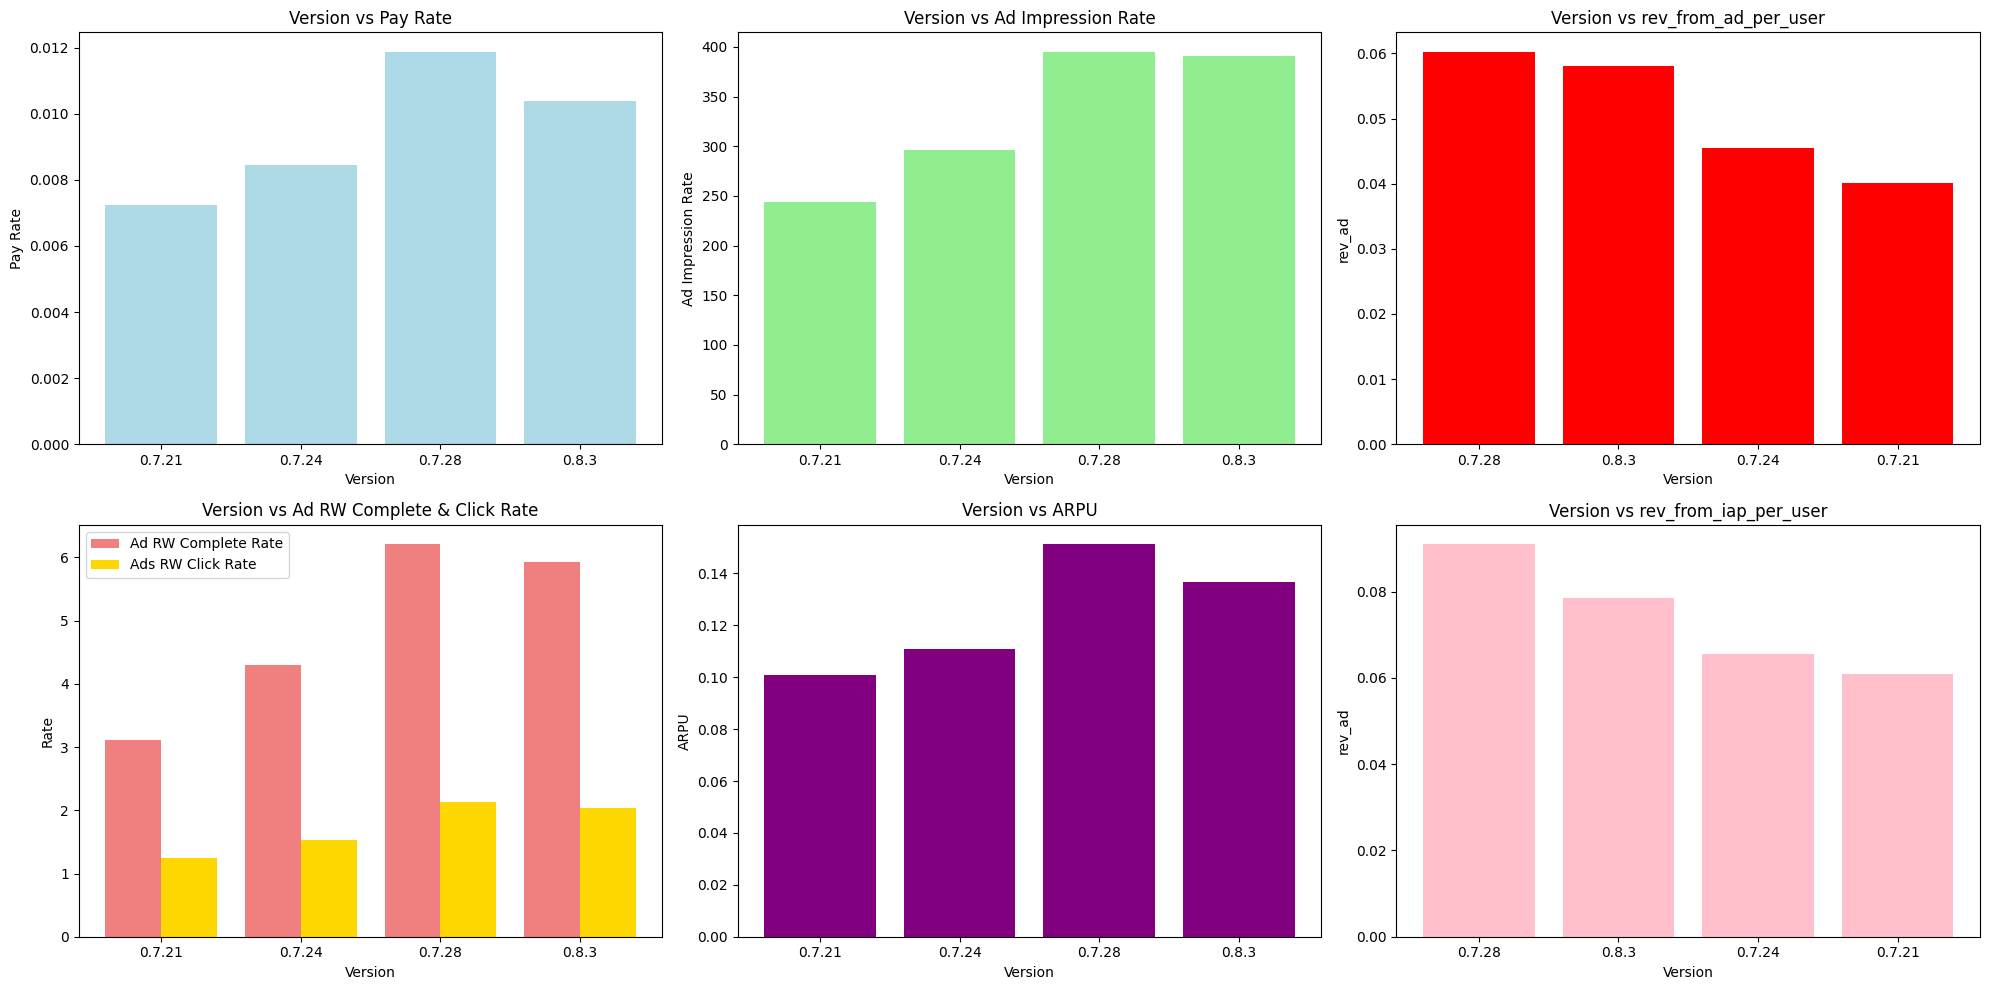

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Kết hợp hai bảng vào một DataFrame duy nhất
combined_data = pay_rate.merge(arpu_data[['version', 'ARPU']], on='version')

# Tạo figure với 4 subplots (2x3)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Biểu đồ 1: Version vs Pay Rate
axes[0, 0].bar(combined_data['version'], combined_data['pay_rate'], color='lightblue')
axes[0, 0].set_title('Version vs Pay Rate')
axes[0, 0].set_xlabel('Version')
axes[0, 0].set_ylabel('Pay Rate')

# Biểu đồ 2: Version vs Ad Impression Rate
axes[0, 1].bar(combined_data['version'], combined_data['ad_impression_rate'], color='lightgreen')
axes[0, 1].set_title('Version vs Ad Impression Rate')
axes[0, 1].set_xlabel('Version')
axes[0, 1].set_ylabel('Ad Impression Rate')

# Biểu đồ 3: Version vs Ad RW Complete Rate & Ads RW Click Rate
x = np.arange(len(combined_data['version']))  # Vị trí của các phiên bản
width = 0.4  # Độ rộng của mỗi cột
axes[1, 0].bar(x - width/2, combined_data['ad_rw_complete_rate'], width, label='Ad RW Complete Rate', color='lightcoral')
axes[1, 0].bar(x + width/2, combined_data['ads_rw_click_rate'], width, label='Ads RW Click Rate', color='gold')
axes[1, 0].set_title('Version vs Ad RW Complete & Click Rate')
axes[1, 0].set_xlabel('Version')
axes[1, 0].set_ylabel('Rate')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(combined_data['version'])
axes[1, 0].legend()

# Biểu đồ 4: Version vs ARPU
axes[1, 1].bar(combined_data['version'], combined_data['ARPU'], color='purple')
axes[1, 1].set_title('Version vs ARPU')
axes[1, 1].set_xlabel('Version')
axes[1, 1].set_ylabel('ARPU')

# Biểu đồ 5: Version vs ad_per_user
axes[0, 2].bar(rev['version'], rev['rev_from_ad_per_user'], color='red')
axes[0, 2].set_title('Version vs rev_from_ad_per_user')
axes[0, 2].set_xlabel('Version')
axes[0, 2].set_ylabel('rev_ad')

# Biểu đồ 6: Version vs ad_per_user
axes[1, 2].bar(rev['version'], rev['rev_from_iap_per_user'], color='pink')
axes[1, 2].set_title('Version vs rev_from_iap_per_user')
axes[1, 2].set_xlabel('Version')
axes[1, 2].set_ylabel('rev_ad')


# Tối ưu bố cục và hiển thị biểu đồ
plt.tight_layout()
plt.show()


### Level Churn

In [ ]:
query = """
SELECT
  SAFE_CAST(level AS STRING) AS level,
  version,
  COUNT(CASE WHEN event_name = 'start_level' THEN user_pseudo_id END) AS event_start,
  COUNT(CASE WHEN event_name = 'win_level'  THEN user_pseudo_id END) AS event_win,
  COUNT(CASE WHEN event_name = 'lose_level'  THEN user_pseudo_id END) AS event_lose,
  COUNT(DISTINCT CASE WHEN event_name = 'start_level' THEN user_pseudo_id END) AS user_start,
  COUNT(DISTINCT CASE WHEN event_name = 'win_level'  THEN user_pseudo_id END) AS user_win,
  COUNT(DISTINCT CASE WHEN event_name = 'lose_level'  THEN user_pseudo_id END) AS event_lose,
FROM
(
  SELECT
    user_pseudo_id,
    event_name,
    version,
    COALESCE(
      (SELECT SAFE_CAST(value.int_value AS STRING) FROM UNNEST(event_params) WHERE KEY = 'level'),
      (SELECT value.string_value FROM UNNEST(event_params) WHERE KEY = 'level')
    ) AS level
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name IN ('start_level', 'win_level','lose_level')
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
  AND user_pseudo_id in
(SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States')
)
GROUP BY level, version
HAVING SAFE_CAST(level AS INT64) < 50
ORDER BY SAFE_CAST(level AS INT64);
"""

winrate = client.query(query).to_dataframe()

winrate['winrate'] = winrate['event_win'] / (winrate['event_win'] + winrate['event_lose'])
winrate['winrate_percent'] = winrate['winrate'] * 100
winrate_df = winrate.copy()
# Ensure that 'version' is treated as a string to match correctly
winrate_df['version'] = winrate_df['version'].astype(str)

# Convert 'level' to numeric, forcing any non-numeric entries to NaN
winrate_df['level'] = pd.to_numeric(winrate_df['level'], errors='coerce')

# Drop rows where level is NaN (caused by non-numeric levels)
winrate_df = winrate_df.dropna(subset=['level'])

# Create a dictionary mapping version to user_start of level 1
level_1_user_start = winrate_df[winrate_df['level'] == 1].set_index('version')['user_start'].to_dict()

# Map the dictionary to create the user_drop column
winrate_df['user_drop'] = winrate_df.apply(lambda row: row['user_start'] / level_1_user_start.get(str(row['version']), float('nan')), axis=1)
winrate_df

,level,version,event_start,event_win,event_lose,user_start,user_win,event_lose_1,winrate,winrate_percent,user_drop
0,1,0.7.28,15010,11752,407,13130,11611,353,0.966527,96.652685,1.000000
1,1,0.7.24,7830,5707,279,6582,5627,249,0.953391,95.339125,1.000000
2,1,0.8.3,15000,11284,469,12766,11124,408,0.960095,96.009529,1.000000
3,1,0.7.21,18305,12797,750,14915,12577,647,0.944637,94.463719,1.000000
4,2,0.7.28,14656,10387,919,11466,10273,576,0.918716,91.871573,0.873267
...,...,...,...,...,...,...,...,...,...,...,...
191,48,0.8.3,1584,1185,970,1057,1174,655,0.549884,54.988399,0.082798
192,49,0.7.28,1465,1109,292,1016,1106,206,0.791577,79.157744,0.077380
193,49,0.7.21,775,539,188,489,535,107,0.741403,74.140303,0.032786
194,49,0.8.3,1799,1154,478,1063,1149,231,0.707108,70.710784,0.083268


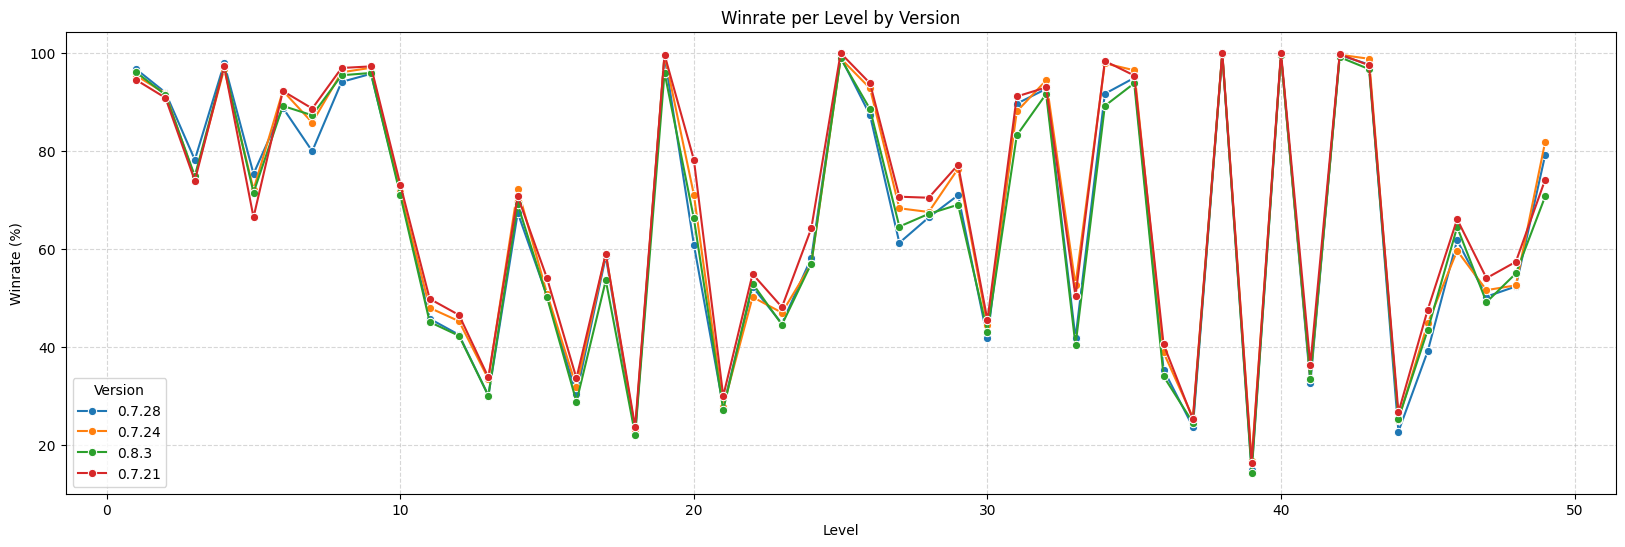

In [ ]:
# Vẽ
plt.figure(figsize=(20, 6))
sns.lineplot(data=winrate_df, x="level", y="winrate_percent", hue="version", marker="o")

plt.title("Winrate per Level by Version")
plt.xlabel("Level")
plt.ylabel("Winrate (%)")
plt.legend(title="Version")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

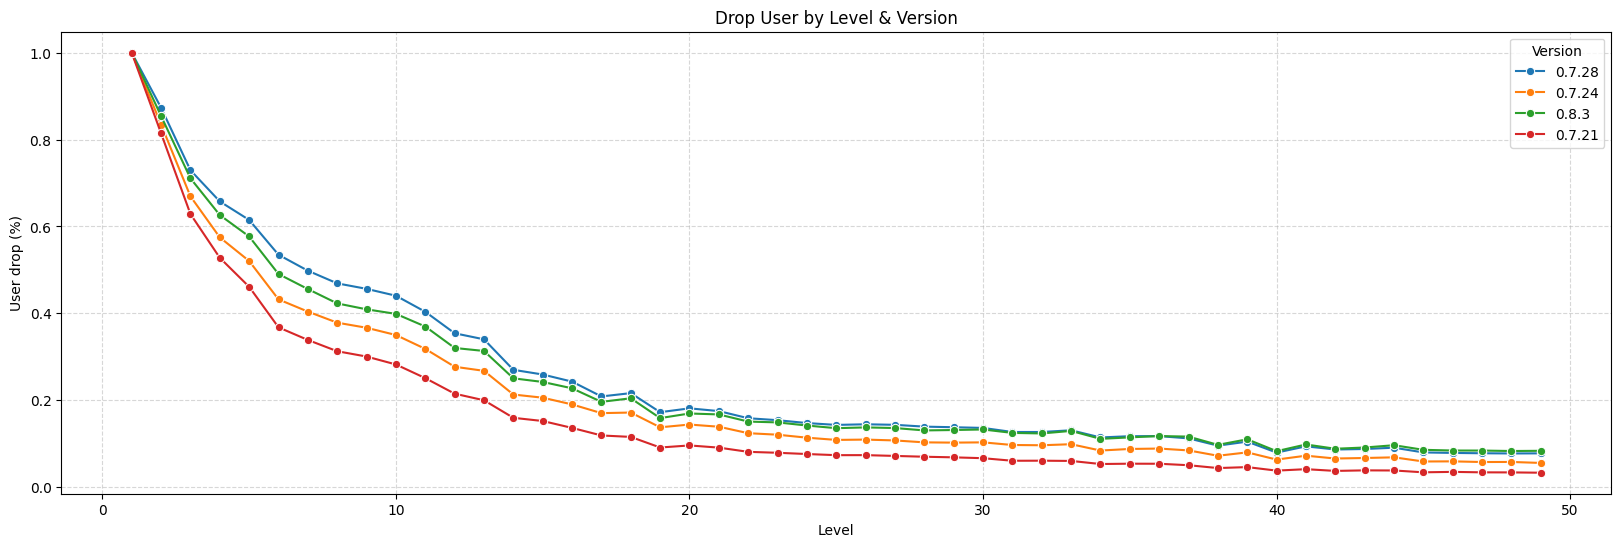

In [ ]:
# Vẽ
plt.figure(figsize=(20, 6))
sns.lineplot(data= winrate_df, x="level", y="user_drop", hue="version", marker="o")

plt.title("Drop User by Level & Version")
plt.xlabel("Level")
plt.ylabel("User drop (%)")
plt.legend(title="Version")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [ ]:
query = """
WITH user_new AS (
    SELECT version, count(distinct user_pseudo_id) as new_user
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`
    WHERE event_name = 'first_open'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
      group by version
),
user_finish_level_30 AS (
    SELECT
        version,
        COUNT(DISTINCT user_pseudo_id) AS user_finish
    FROM `royal-hexa-in-house.pixon_data_science.003_mock`,
    UNNEST(event_params) AS param
    WHERE event_name = 'win_level'
        AND param.key = 'level'
        AND param.value.string_value = '30'
        AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3')
        AND platform = 'ANDROID'
        AND country = 'United States'
        AND user_pseudo_id in
(SELECT user_pseudo_id
FROM `royal-hexa-in-house.pixon_data_science.003_mock`
WHERE event_name = 'first_open'
  AND ((version = '0.7.21' AND date_par BETWEEN '2025-02-02' AND '2025-02-08')
    OR (version = '0.7.24' AND date_par BETWEEN '2025-02-08' AND '2025-02-14')
    OR (version = '0.7.28' AND date_par BETWEEN '2025-02-13' AND '2025-02-19')
    OR (version = '0.8.3' AND date_par BETWEEN '2025-02-20' AND '2025-02-26'))
  AND version IN ('0.7.21','0.7.24','0.7.28','0.8.3') AND platform = 'ANDROID' AND country = 'United States')
GROUP BY version)
SELECT
  un.version,
  uf.user_finish / un.new_user AS finish_rate
 FROM user_finish_level_30 uf join user_new un on uf.version = un.version ;
"""
finish_rate = client.query(query).to_dataframe()
finish_rate

,version,finish_rate
0,0.7.24,0.102522
1,0.7.28,0.153995
2,0.7.21,0.076025
3,0.8.3,0.153970


<ipython-input-52-c1d5f0e34d07>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=finish_rate, x="version", y="finish_rate", palette="viridis")


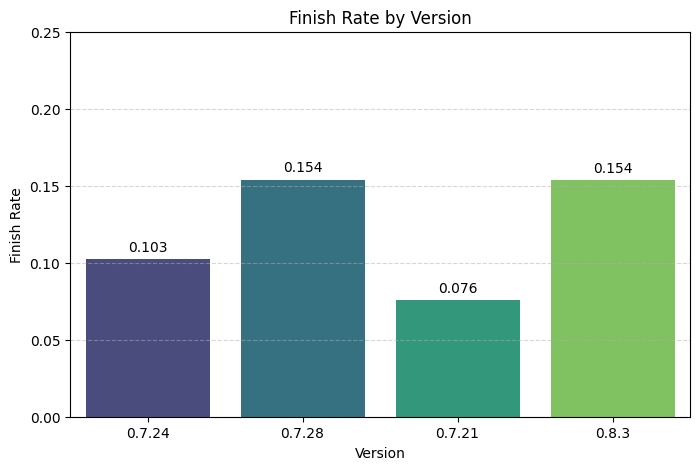

In [ ]:
# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
sns.barplot(data=finish_rate, x="version", y="finish_rate", palette="viridis")

# Thêm nhãn và tiêu đề
plt.xlabel("Version")
plt.ylabel("Finish Rate")
plt.title("Finish Rate by Version")
plt.ylim(0, 0.25)  # Điều chỉnh trục y nếu cần
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Hiển thị giá trị trên cột
for index, row in finish_rate.iterrows():
    plt.text(index, row.finish_rate + 0.005, round(row.finish_rate, 3), ha="center", fontsize=10)

plt.show()

### LTV

In [ ]:
query = """
WITH cohort AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS cohort_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'first_open' and version IN ('0.7.21') AND platform = 'ANDROID' AND country = 'United States'
  and date_par between '2025-02-02' and '2025-02-08'
),

sessions AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS session_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'session_start' and version IN ('0.7.21') AND platform = 'ANDROID' AND country = 'United States'
  and date_par between '2025-02-02' and '2025-02-08'
),
revenue AS (
SELECT
  hihi.revenue_date,
  hihi.user_id,
  IFNULL(hihi.rev_ads, 0) + IFNULL(hihi.rev_iap, 0) as revenue
FROM (
  SELECT
    date_par as revenue_date,
    user_pseudo_id as user_id,
    SUM(IFNULL(event_value_in_usd, 0)) as rev_iap,
    SUM(IFNULL((SELECT value.double_value FROM UNNEST(event_params) WHERE KEY = 'value'), 0)) AS rev_ads
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name in('in_app_purchase','ad_impression') and version IN ('0.7.21') and date_par between '2025-02-02' and '2025-02-08' AND platform = 'ANDROID' AND country = 'United States'
  GROUP BY 1,2
) as hihi
),

cohort_revenue AS (
  SELECT
    c.user_id,
    c.cohort_date,
    r.revenue_date,
    DATE_DIFF(r.revenue_date, c.cohort_date, DAY) AS day_number,
    IFNULL(r.revenue, 0) AS revenue
  FROM cohort c
  LEFT JOIN revenue r
    ON c.user_id = r.user_id
    AND r.revenue_date >= c.cohort_date
)

SELECT
  c.cohort_date,
  COUNT(DISTINCT c.user_id) AS total_users,
  COALESCE(SUM(CASE WHEN cr.day_number = 0 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS Day_0_ARPU,
  COALESCE(SUM(CASE WHEN cr.day_number <= 1 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_1,
  COALESCE(SUM(CASE WHEN cr.day_number <= 7 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_7
FROM cohort c
LEFT JOIN cohort_revenue cr
  ON c.user_id = cr.user_id
GROUP BY 1
ORDER BY 1;
"""

query1 = """
WITH cohort AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS cohort_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'first_open' and version IN ('0.7.24') AND platform = 'ANDROID' AND country = 'United States'
  and date_par between '2025-02-08' and '2025-02-14'
),

sessions AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS session_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'session_start' and version IN ('0.7.24') AND platform = 'ANDROID' AND country = 'United States'
  and date_par between '2025-02-08' and '2025-02-14'
),

revenue AS (
SELECT
  hihi.revenue_date,
  hihi.user_id,
  IFNULL(hihi.rev_ads, 0) + IFNULL(hihi.rev_iap, 0) as revenue
FROM (
  SELECT
    date_par as revenue_date,
    user_pseudo_id as user_id,
    SUM(IFNULL(event_value_in_usd, 0)) as rev_iap,
    SUM(IFNULL((SELECT value.double_value FROM UNNEST(event_params) WHERE KEY = 'value'), 0)) AS rev_ads
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name in('in_app_purchase','ad_impression') and version IN ('0.7.24') and date_par between '2025-02-08' and '2025-02-14' AND platform = 'ANDROID' AND country = 'United States'
  GROUP BY 1,2
) as hihi
),

cohort_revenue AS (
  SELECT
    c.user_id,
    c.cohort_date,
    r.revenue_date,
    DATE_DIFF(r.revenue_date, c.cohort_date, DAY) AS day_number,
    IFNULL(r.revenue, 0) AS revenue
  FROM cohort c
  LEFT JOIN revenue r
    ON c.user_id = r.user_id
    AND r.revenue_date >= c.cohort_date
)

SELECT
  c.cohort_date,
  COUNT(DISTINCT c.user_id) AS total_users,
  COALESCE(SUM(CASE WHEN cr.day_number = 0 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS Day_0_ARPU,
  COALESCE(SUM(CASE WHEN cr.day_number <= 1 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_1,
  COALESCE(SUM(CASE WHEN cr.day_number <= 7 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_7,
  COALESCE(SUM(cr.revenue), 0) / COUNT(DISTINCT c.user_id) AS LTV_Total
FROM cohort c
LEFT JOIN cohort_revenue cr
  ON c.user_id = cr.user_id
GROUP BY 1
ORDER BY 1;
"""

query2= """
WITH cohort AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS cohort_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'first_open' and version IN ('0.7.28') AND platform = 'ANDROID' AND country = 'United States'
  and date_par between '2025-02-13' and '2025-02-19'
),

sessions AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS session_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'session_start' and version IN ('0.7.28') AND platform = 'ANDROID' AND country = 'United States'
  and date_par between '2025-02-13' and '2025-02-19'
),

revenue AS (
SELECT
  hihi.revenue_date,
  hihi.user_id,
  IFNULL(hihi.rev_ads, 0) + IFNULL(hihi.rev_iap, 0) as revenue
FROM (
  SELECT
    date_par as revenue_date,
    user_pseudo_id as user_id,
    SUM(IFNULL(event_value_in_usd, 0)) as rev_iap,
    SUM(IFNULL((SELECT value.double_value FROM UNNEST(event_params) WHERE KEY = 'value'), 0)) AS rev_ads
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name in('in_app_purchase','ad_impression') and version IN ('0.7.28') and date_par between '2025-02-13' and '2025-02-19' AND platform = 'ANDROID' AND country = 'United States'
  GROUP BY 1,2
) as hihi
),

cohort_revenue AS (
  SELECT
    c.user_id,
    c.cohort_date,
    r.revenue_date,
    DATE_DIFF(r.revenue_date, c.cohort_date, DAY) AS day_number,
    IFNULL(r.revenue, 0) AS revenue
  FROM cohort c
  LEFT JOIN revenue r
    ON c.user_id = r.user_id
    AND r.revenue_date >= c.cohort_date
)

SELECT
  c.cohort_date,
  COUNT(DISTINCT c.user_id) AS total_users,
  COALESCE(SUM(CASE WHEN cr.day_number = 0 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS Day_0_ARPU,
  COALESCE(SUM(CASE WHEN cr.day_number <= 1 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_1,
  COALESCE(SUM(CASE WHEN cr.day_number <= 7 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_7,
  COALESCE(SUM(cr.revenue), 0) / COUNT(DISTINCT c.user_id) AS LTV_Total
FROM cohort c
LEFT JOIN cohort_revenue cr
  ON c.user_id = cr.user_id
GROUP BY 1
ORDER BY 1;
"""

query3= """
WITH cohort AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS cohort_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'first_open' and version IN ('0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  and date_par between '2025-02-20' and '2025-02-26'
),

sessions AS (
  SELECT
    user_pseudo_id AS user_id,
    date_par AS session_date
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name = 'session_start' and version IN ('0.8.3') AND platform = 'ANDROID' AND country = 'United States'
  and date_par between '2025-02-20' and '2025-02-26'
),

revenue AS (
SELECT
  hihi.revenue_date,
  hihi.user_id,
  IFNULL(hihi.rev_ads, 0) + IFNULL(hihi.rev_iap, 0) as revenue
FROM (
  SELECT
    date_par as revenue_date,
    user_pseudo_id as user_id,
    SUM(IFNULL(event_value_in_usd, 0)) as rev_iap,
    SUM(IFNULL((SELECT value.double_value FROM UNNEST(event_params) WHERE KEY = 'value'), 0)) AS rev_ads
  FROM `royal-hexa-in-house.pixon_data_science.003_mock`
  WHERE event_name in('in_app_purchase','ad_impression') and version IN ('0.8.3') and date_par between '2025-02-20' and '2025-02-26' AND platform = 'ANDROID' AND country = 'United States'
  GROUP BY 1,2
) as hihi
),

cohort_revenue AS (
  SELECT
    c.user_id,
    c.cohort_date,
    r.revenue_date,
    DATE_DIFF(r.revenue_date, c.cohort_date, DAY) AS day_number,
    IFNULL(r.revenue, 0) AS revenue
  FROM cohort c
  LEFT JOIN revenue r
    ON c.user_id = r.user_id
    AND r.revenue_date >= c.cohort_date
)

SELECT
  c.cohort_date,
  COUNT(DISTINCT c.user_id) AS total_users,
  COALESCE(SUM(CASE WHEN cr.day_number = 0 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS Day_0_ARPU,
  COALESCE(SUM(CASE WHEN cr.day_number <= 1 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_1,
  COALESCE(SUM(CASE WHEN cr.day_number <= 7 THEN cr.revenue END), 0) / COUNT(DISTINCT c.user_id) AS LTV_Day_7,
  COALESCE(SUM(cr.revenue), 0) / COUNT(DISTINCT c.user_id) AS LTV_Total
FROM cohort c
LEFT JOIN cohort_revenue cr
  ON c.user_id = cr.user_id
GROUP BY 1
ORDER BY 1;
"""

# To data frame
ltv_0_7_21 = client.query(query).to_dataframe()
ltv_0_7_24 = client.query(query1).to_dataframe()
ltv_0_7_28 = client.query(query2).to_dataframe()
ltv_0_8_3 = client.query(query3).to_dataframe()

# Style the DataFrame
ltv_0_7_21 = ltv_0_7_21.style.background_gradient(cmap='Greens', axis=0)
ltv_0_7_24 = ltv_0_7_24.style.background_gradient(cmap='Greens', axis=0)
ltv_0_7_28 = ltv_0_7_28.style.background_gradient(cmap='Greens', axis=0)
ltv_0_8_3 = ltv_0_8_3.style.background_gradient(cmap='Greens', axis=0)

import pandas as pd
from IPython.display import HTML, display
html_str = f"""
<div style="display: flex; justify-content: space-around;">
    <div style="margin: 10px;">
        <h3>ltv_0_7_21</h3>
        {ltv_0_7_21.to_html()}
    </div>
    <div style="margin: 10px;">
        <h3>ltv_0_7_24</h3>
        {ltv_0_7_24.to_html()}
    </div>
    <div style="margin: 10px;">
        <h3>ltv_0_7_28</h3>
        {ltv_0_7_28.to_html()}
    </div>
    <div style="margin: 10px;">
        <h3>ltv_0_8_3</h3>
        {ltv_0_8_3.to_html()}
    </div>
</div>
"""

# Display the HTML structure
display(HTML(html_str))


### Kết luận

TỔng kết các chỉ số:
- Retention: 0.8.3 > 0.7.28 > 0.7.21 > 0.7.24
- Playtime: 0.8.3 và 0.7.28 tốt hơn 2 version còn lại
- Avg time per session & Avg time per user: 0.8.3 và 0.7.28 tốt hơn 2 version còn lại
- Avg session per user: 0.8.3 > 0.7.28 > 2 version còn lại (0.8.3 nhỉnh lên 1 chút so với 0.7.28)
- ARPU: 0.7.28 > 0.8.3 > 2 version còn lại
- Pay rate: 0.7.28 > 0.8.3 > 2 chỉ số còn lại
- Ad Shown rate & Ads Reward Complete: 0.7.28 > 0.8.3 (nhỉnh hơn 1 chút)
- Level Churn: 0.8.3 > 0.7.24
- Finish lv30 rate: 0.7.28 = 0.8.3
- LTV: 0.7.28 > 0.8.3